# Solving Classical Dynamics (Hamiltonian)

In [1]:
#Load necessary packages
# %pylab notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pylab as pl
from matplotlib.animation import FuncAnimation
import scipy as sp
from scipy.sparse import linalg as ln
from IPython.display import HTML
from random import choices

try:
    plt.style.use('classic')
except:
    pass

# Use ODEINT to solve the differential equations defined by the vector field
# from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Setting up the system

In [71]:
#Define parameters, potential and vector potential
m, omega , eps =  1., 1., 0.5

levelSpace = 0.46638204451990617 # eps = 0.5
beta = 0.1/ (levelSpace)

print("beta=", beta)
print("T=", 1/beta)

Ed = 0.1
omegaD = Ed / eps

def confin(x): 
    left = 20*(1+np.tanh(20*(x-np.pi)))
    right = 20*(1-np.tanh(20*(x+np.pi)))
    return left + right

def V(x,y):
#     return omega/4 * (x**2 + y**2 + x**2*y**2)
#     return omega/4 * (x**4 + 2.5*y**4 + x**2*y**2)
    return omega/4 * (x**2 + 2.5*y**2 + x**2*y**2)

#Define range of x
x_max = np.pi
x_min = -np.pi
dx = 0.1
x_range_q = np.append(np.flip(-1*np.arange(0+dx,x_max,dx)), np.arange(0,x_max,dx))
n_xq = len(x_range_q); 
print("n_xq=",n_xq )

#Define range of p
p_max = 15
p_min = -15
dp = 0.01
p_range_q = np.arange(p_min,p_max+dp,dp)
n_pq = len(p_range_q); 
print("n_pq=",n_pq )


##Plotting checking of Potential
# Plot EigenStates
fig1 = plt.figure(figsize = (6,3), dpi=100)
ax1 = fig1.add_subplot(111)
ax1.plot(x_range_q,V(x_range_q,2), color='black')

beta= 0.21441648788803616
T= 4.663820445199062
n_xq= 63
n_pq= 3001


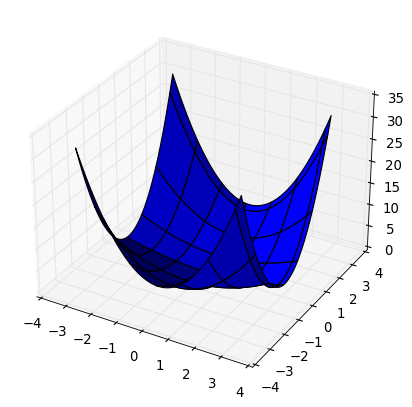

In [5]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(frameon=False)
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_range_q, x_range_q)
zs = np.array(V(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

## Compute quasi-Density matrix, $W$

For Gibb's distribution, the quasi-density matrix is

\begin{equation} 
\mathcal{W}(x_1, y_1, x_2, y_2) = \frac{1}{\mathcal{Z}} \exp\left[ -\frac{m}{2\beta \epsilon^2} ( \xi_x^2 + \xi_y^2 ) - \beta V(x, y)
 \right] \\ 
x_1 = x + \frac{\xi_x}{2}, y_1 = y + \frac{\xi_y}{2}, x_2 = x - \frac{\xi_x}{2}, y_2 = y - \frac{\xi_y}{2}
\end{equation}

### Set up system and functions

In [29]:
def W(x1, y1, x2, y2, beta): 
    x_x = (x1+x2)/2
    xi_x = x1-x2
    y_y = (y1+y2)/2
    xi_y = y1-y2
    return np.exp(-beta*V(x_x, y_y))*np.exp(-m*(xi_x**2+xi_y**2)/(2.*eps**2*beta))

def diagW(beta): 
    """
    Compute and Diagonalize W in 2d for given temperature, $T$. 
    """
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.1

    #Define extended range of x
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.append(np.flip(-1*np.arange(dx,x1_max+dx+sigma_x,dx)), np.arange(0,x1_max+dx+sigma_x,dx))
    n_x1q = len(x1_range_q); 

    #Define range of x
    x_range_q = np.append(np.flip(-1*np.arange(dx,x1_max,dx)), np.arange(0,x1_max,dx))
    n_xq = len(x_range_q);
    found_x_beg = np.where(x1_range_q ==x_range_q[0])[0][0]
    found_x_end = -1*(found_x_beg)

    ## Compute the W-function
    W_mat = np.zeros((n_x1q**2, n_x1q**2), dtype=complex)
    Z_x = 0
    for x_i in range(n_xq): 
        for y_i in range(n_xq): 
            Z_x += np.exp(-beta*V(x_range_q[x_i], x_range_q[y_i]))

    for i in range(n_x1q):
        for j in range(n_x1q): 
            for k in range(n_x1q): 
                for l in range(n_x1q): 
                    c_1 = n_x1q * i + j
                    c_2 = n_x1q * k + l
                    W_mat[c_1, c_2] += W(x1_range_q[i],x1_range_q[j],x1_range_q[k],x1_range_q[l], beta)/Z_x
                    
    ## Diagonalize the W-function
    w_alph, psi_alph = np.linalg.eigh(W_mat)
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
        
    return W_mat, sorted_w_alph, sorted_psi_alph

#### Testing the 2d $W$-diagonalizer. 

In [24]:
W_mat, w_alph, psi_alph = diagW(1)

(5625, 5625)
Check hermiticity: 0.0


In [35]:
np.unique(w_alph < 0, return_counts=True)

(array([False,  True]), array([2820, 2805]))

In [36]:
psi_alph[:,0]

array([ 0.00000000e+00+0.j, -8.47901079e-14+0.j, -3.79344832e-13+0.j, ...,
       -6.81408857e-18+0.j, -1.70291396e-18+0.j,  8.79353114e-29+0.j])

In [26]:
print(np.sum(w_alph))

plt.figure(figsize=[10,10])
plt.imshow(W_mat.real,vmin=-0.1,vmax=0.1)
plt.colorbar()
#plt.savefig('2DMicrocan.pdf')
plt.show()

1.000000000000668


### Computing W for $\beta$ range around the crossings

In [30]:
def comp_Write_Weights(beta): 
    W_mat, w_alph, psi_alph = diagW(beta)

    ## Write the weights to a text file
    filename = "diagW/SingleT_2dseparable/JJ_CM_weights_nearMore" +str(round(beta, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, w_alph, delimiter=',')

    ## Write the states to a text file
    filename = "diagW/SingleT_2dseparable/JJ_CM_states_nearMore" +str(round(beta, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, psi_alph[:,:10], delimiter=',', header=listToStr, comments='#')

beta_list_fine = np.linspace(1.0, 3.0, 50) / levelSpace

for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, end=" ")
    comp_Write_Weights(beta)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [12]:
beta = beta_Range[3]

W_mat_t, w_alph_t, psi_alph_t = diagW(beta)

In [13]:
print(np.shape(W_mat_t))
print(np.shape(w_alph_t))
print(np.shape(psi_alph_t))

(6561, 6561)
(6561,)
(6561, 6561)


### Analysing the 2D quartic potential 

`2dquart`: 

$$ V(x,y) = \frac{\omega}{4} ( x^2 + y^2 + x^2y^2) $$

`2dasym`: 

$$ V(x,y) = \frac{\omega}{4} ( x^2 + 2.5y^2 + x^2y^2) $$

notice now that the $x$ and $y$ are not symmetric, one term as an extra factory breaking that symmetry. 

In [43]:
## Read from file
def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
#         w_alph = np.loadtxt("diagW/SingleT_2dquart/"+filename,dtype = "complex", delimiter=',', comments='#')
#         w_alph = np.loadtxt("diagW/SingleT_2dseparable/"+filename,dtype = "complex", delimiter=',', comments='#')
        w_alph = np.loadtxt("diagW/SingleT_2dasym/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]]
    return weights_list

beta_list_fine = np.linspace(0.1, 4.0, 50) / levelSpace
beta_list_fine = np.linspace(1.0, 3.0, 50) / levelSpace
beta_Range = beta_list_fine
file_save_base = "2dasym"
w_alph_list_fine = readInNew("JJ_CM_weights_nearMore", beta_list_fine)

print("Found this many weights:", np.shape(w_alph_list_fine))

Found this many weights: (50, 600)


#### Weights and Energy spectrum

Plots_W/CM_eps0.5_E_v_beta_2dquart.png


<ipython-input-44-6c25b7532359>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_check[j_i] = np.sum(w_alph_list_fine[j_i])


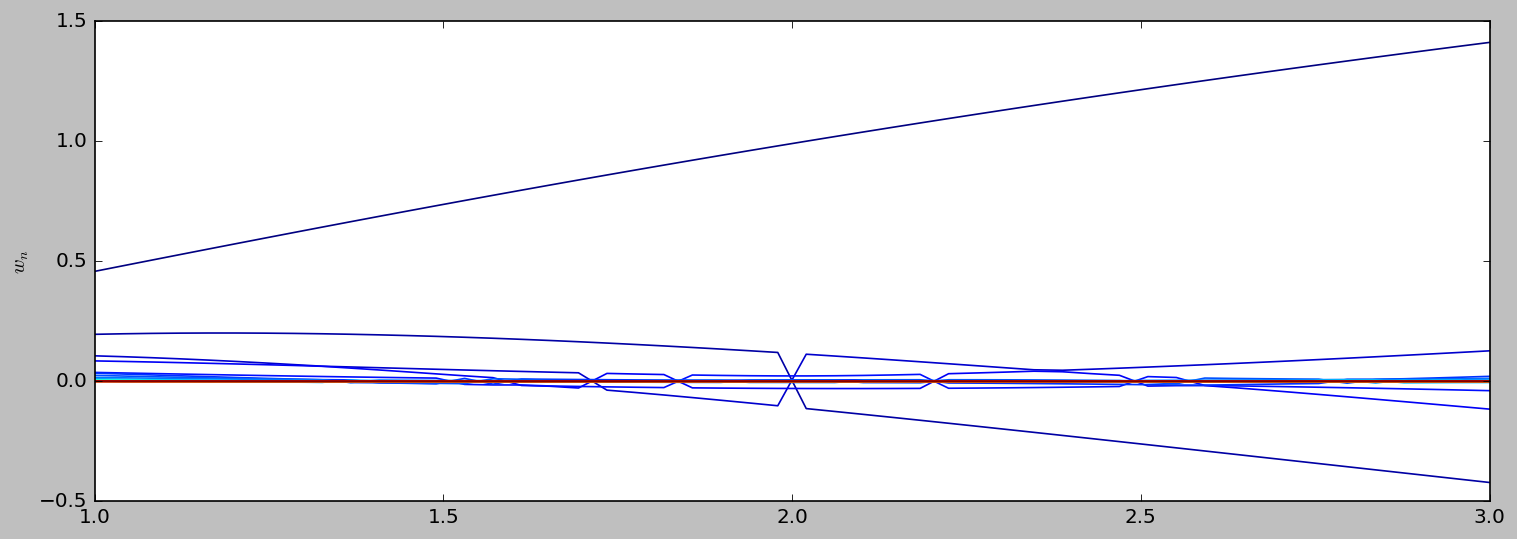

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6), dpi=120, frameon=True)
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 30

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))
sum_check = np.zeros(len(beta_list_fine))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i] + np.log(np.abs(w_alph_list_fine[j_i][0]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k])) + np.log(np.abs(w_alph_list_fine[j_i][0]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        sum_check[j_i] = np.sum(w_alph_list_fine[j_i])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))
    ax3.plot(beta_list_fine*levelSpace, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"$\beta E_n$")
ax3.set_ylabel(r"$w_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
# ax1.set_xlim([1,4])
ax1.set_ylim([0,4])
# ax2.set_xlim([1,4])
# ax3.set_xlim([1,4])
ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

filename = "Plots_W/CM_eps"+str(eps)+"_E_v_beta_2dquart.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


Plots_W/CM_eps0.5_E_v_beta_2dquart_zoom.png


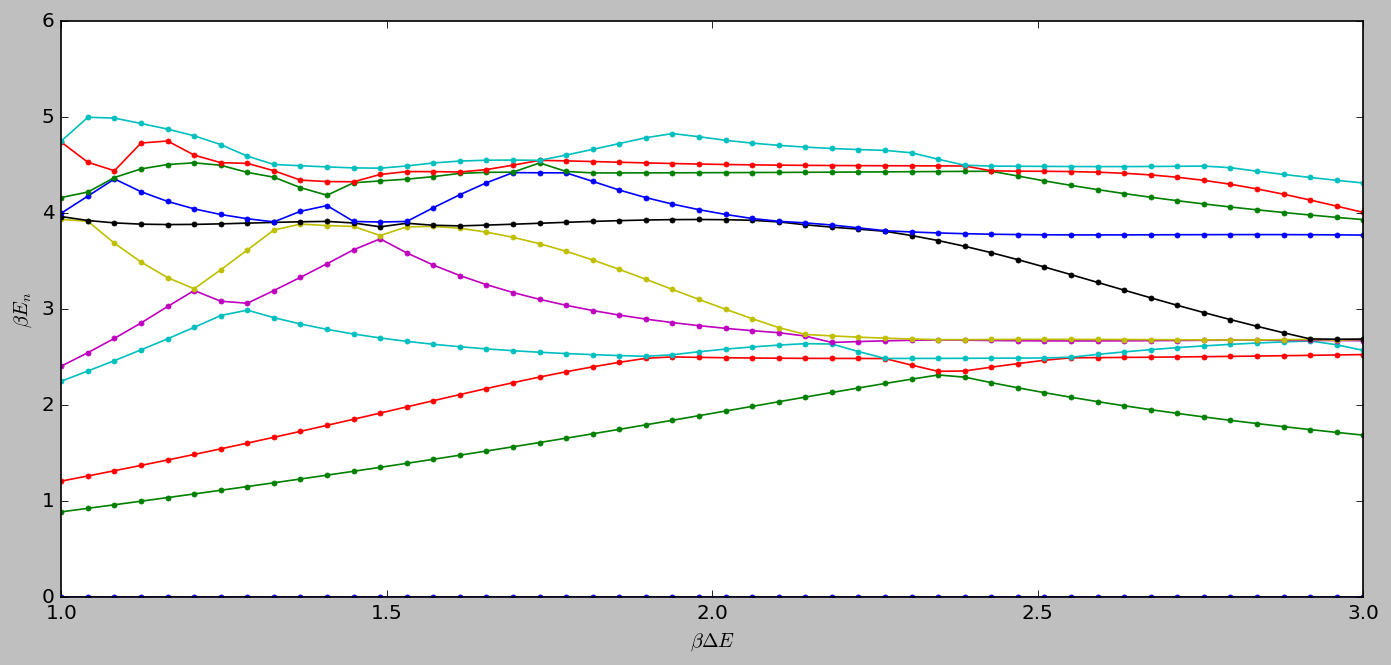

In [33]:
f, (ax1) = plt.subplots(1, 1, figsize = (14,6), dpi=120, frameon=True)

states_n = 11

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i] - -np.log(np.abs(w_alph_list_fine[j_i][0]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k])) - -np.log(np.abs(w_alph_list_fine[j_i][0]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '.-', label="n="+str(k))
#     ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k]+0.05*k, '.-', label="n="+str(k))

ax1.set_xlabel(r"$\beta \Delta E $")
ax1.set_ylabel(r"$\beta E_n$")

filename = "Plots_W/CM_eps"+str(eps)+"_E_v_beta_2dquart_zoom.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

#### Weights at given T

Plots_W/JJ_CM_eps0.5_weights_2dasym.png


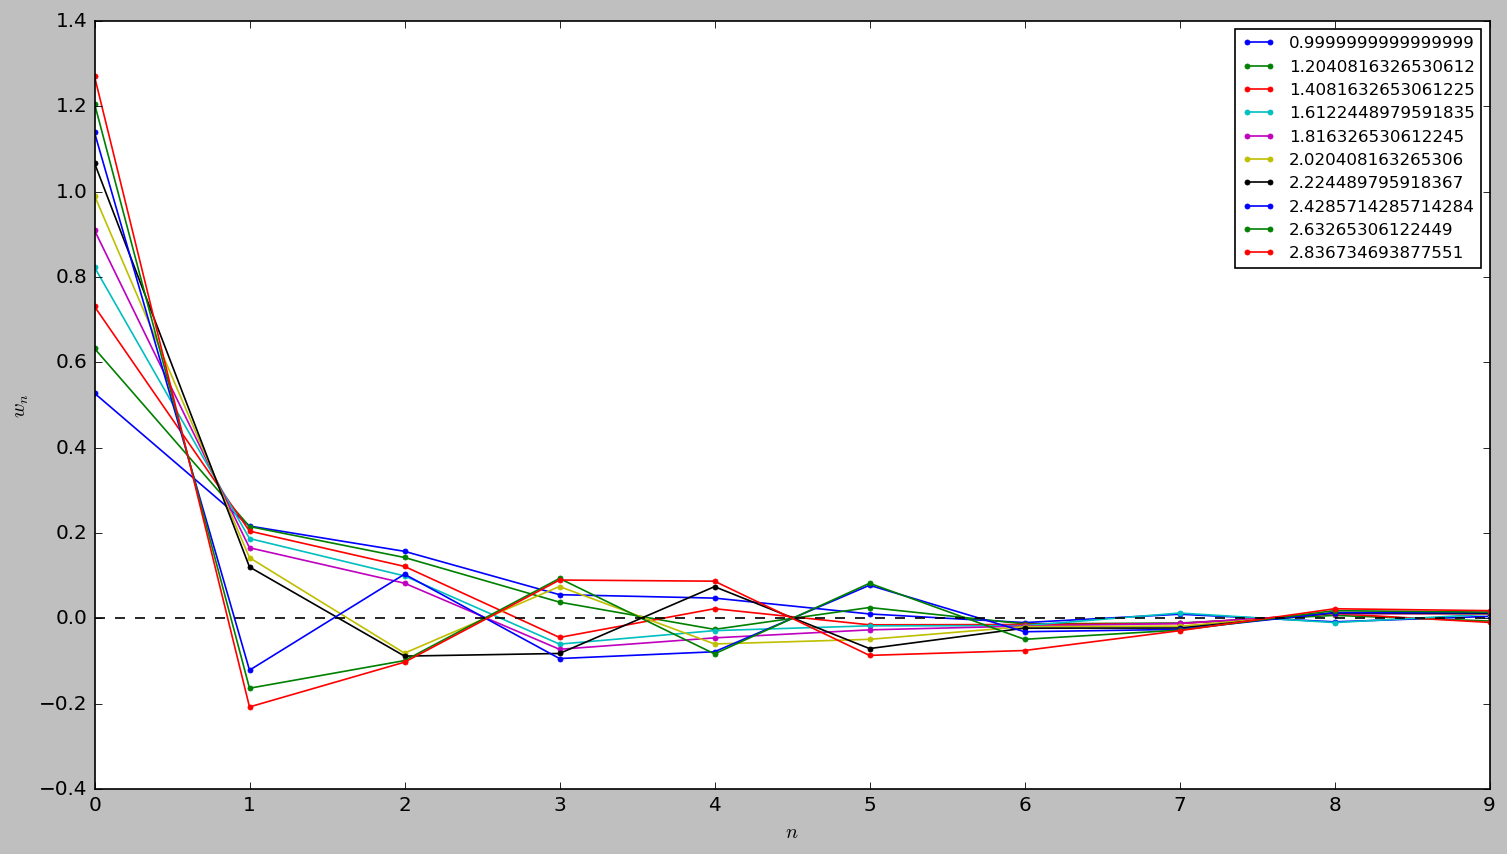

In [34]:
f, ax1 = plt.subplots(1, 1, figsize = (15,8), dpi=120, frameon=True)

for beta_i, beta in enumerate(beta_list_fine):
    if beta_i%5==0:
        ax1.plot(weights_toPlot[beta_i, 0:10], '.-', label=str(beta*levelSpace))
ax1.plot(np.arange(0,10), 0*np.arange(0,10), 'k--')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$w_n$")
ax1.legend(fontsize=10)
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_weights_2dasym.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

#### Entropy

Plots_W/JJ_CM_eps0.5_entropy_quart.png
minimums: [24 26 26 26 26 26] [1 2 2 2 2 2]
vN: 16 1.9387755102040816


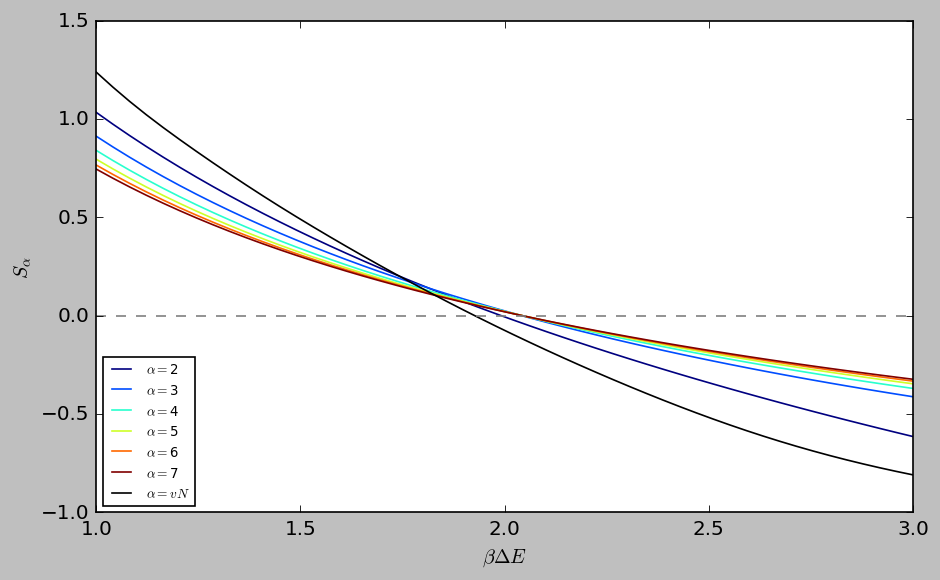

In [35]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)

powerRange = np.arange(2, 8, 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
    ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '-', color=colors[power_i],
             label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '-', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
# ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(fontsize=8, loc=3)
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_quart.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)
print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)


#### 3x3 W Sub-Matrix 

In [97]:
def readInWF(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT_mid/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT_mid/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, sorted_w_alph, sorted_psi_alph

def reconstruct_W(beta): 
    ## Read-in weights/states for given inverse-temperature
    x1_range_q, w_alph, psi_alph = readInWF("JJ_CM_states_nearMore", beta)
    
    ## Construct the W-matrix from weights/states
    n_x1q = len(x1_range_q); 
    P = np.zeros((n_x1q,n_x1q))
    D = np.zeros((n_x1q,n_x1q))

    for i in range(n_x1q): 
        D[i,i] += np.real(w_alph[i])
        P[:,i] += np.real(psi_alph[:,i])

    W_mat_recon =  P@D@np.linalg.inv(P)
    return x1_range_q, w_alph, psi_alph, W_mat_recon

##Define the states for the subspace
chosen_state_j = 20; print(beta_list_fine[chosen_state_j]*levelSpace)
state_range = [1, 2, 3, 4, 5]
new_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
old_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
new_psi_list = np.zeros((len(state_range), len(beta_list_fine), len(state_range)))

##Get eigensystem of W at chosen T
x_range_q, w_alph_j, psi_alph_j, W_mat_recon_j = reconstruct_W(beta_list_fine[chosen_state_j])
x_end_j = np.where(x_range_q == 3.14)[0][0]
x_beg_j = np.where(x_range_q == -3.14)[0][0]
print(x_range_q[x_beg_j], x_range_q[x_end_j])

##Compute the W sub-matrix 
for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, "/",len(beta_list_fine), end='\r')
    x1_range_q, w_alph, psi_alph, W_mat_recon = reconstruct_W(beta)
    x_end = np.where(x1_range_q == 3.14)[0][0]; x_beg = np.where(x1_range_q == -3.14)[0][0]
    
    W_sub = np.zeros((len(state_range), len(state_range)))
    for j_i, j in enumerate(state_range): 
        for k_i, k in enumerate(state_range): 
            W_sub[j_i, k_i] = np.real(psi_alph_j[x_beg_j:x_end_j,k]@W_mat_recon[x_beg:x_end, x_beg:x_end]@psi_alph_j[x_beg_j:x_end_j,j])
    [w_alph_sub, psi_alph_sub] = np.linalg.eigh(W_sub)
    new_eig_list[:,beta_i] += w_alph_sub
    old_eig_list[:,beta_i] += np.real(w_alph[state_range[0]:state_range[-1]+1])
    new_psi_list[:,beta_i,:] += psi_alph_sub

1.702020202020202
-3.14 3.14


Plots_W/JJ_CM_eps0.5_Wsub_weights_12345.png


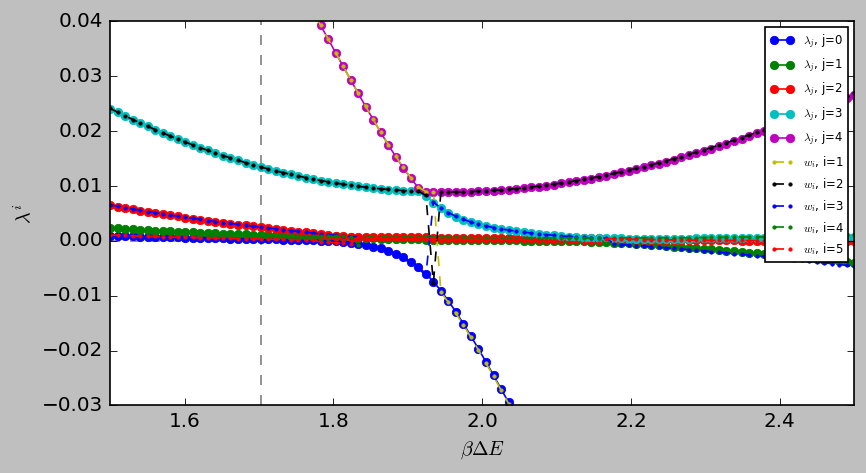

In [110]:
##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=120, frameon=True)
ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.03,0.04,100), '--', color='grey')

for s_i, s in enumerate(state_range): 
    ax1.plot(beta_list_fine*levelSpace, new_eig_list[s_i,:], '.-', markersize=10, label=r"$\lambda_j$, j="+str(s_i))
    
for s_i, s in enumerate(state_range): 
    ax1.plot(beta_list_fine*levelSpace, old_eig_list[s_i,:], '.--', markersize=4, label=r"$w_i$, i="+str(s))
    
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\lambda^i$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
ax1.set_ylim([-0.03, 0.04])

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_weights_12345.png"
f.savefig(filename, dpi=200, bbox_inches='tight')
print(filename)

Plots_W/JJ_CM_eps0.5_Wsub12345_vector0.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector1.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector2.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector3.png
Plots_W/JJ_CM_eps0.5_Wsub12345_vector4.png


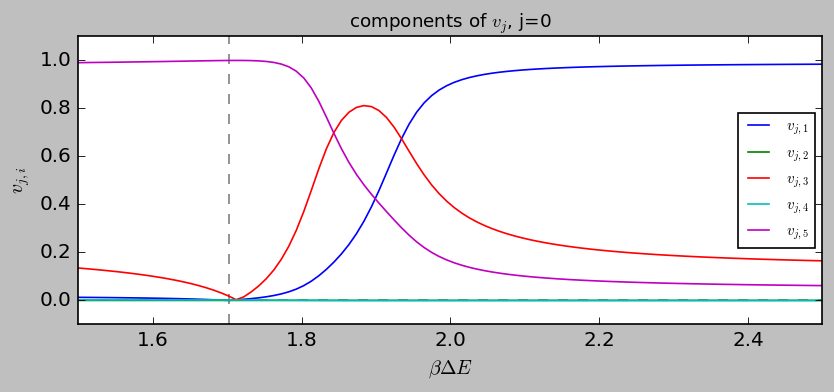

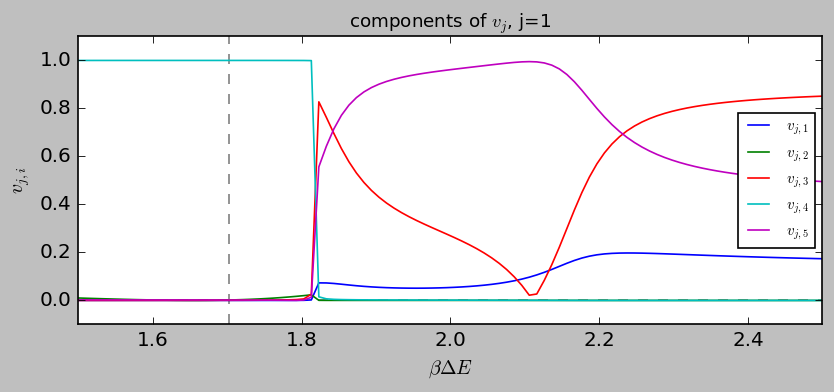

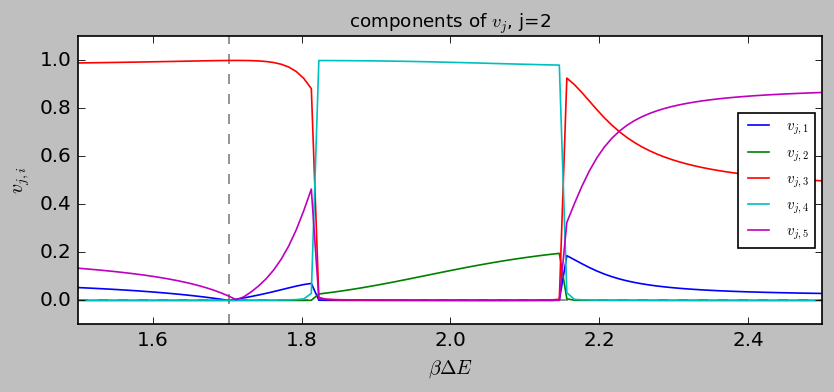

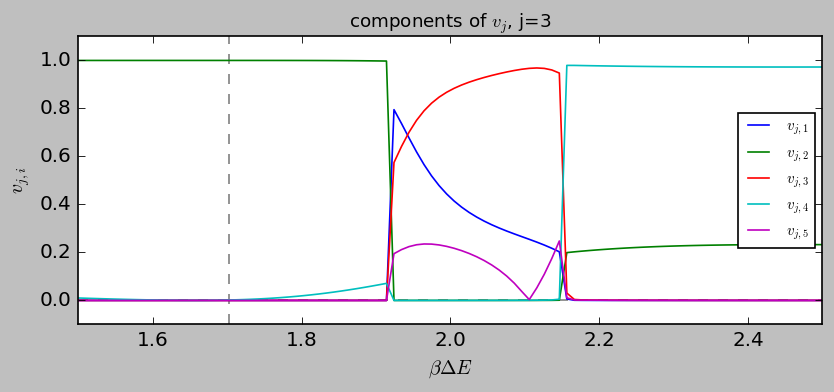

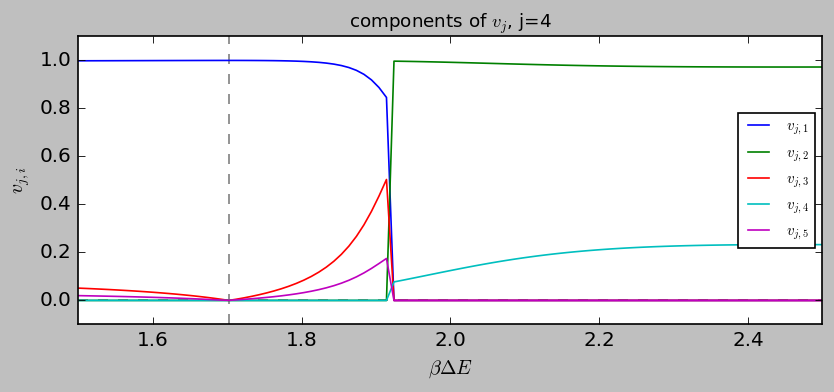

In [103]:
for j in range(len(state_range)): 
    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[0,:,j]), '-', label=r"$v_{j,1}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[1,:,j]), '-', label=r"$v_{j,2}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[2,:,j]), '-', label=r"$v_{j,3}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[3,:,j]), '-', label=r"$v_{j,4}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[4,:,j]), '-', label=r"$v_{j,5}$")
    # ax1.plot(beta_list_fine*levelSpace, new_eig_list[3,:], '.-', label=r"$\lambda_3$")
    ax1.legend(fontsize=9, loc=7)

    ax1.set_title("components of $v_j$, j="+str(j), fontsize=11)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_ylabel(r"$v_{j,i}$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)
#     ax1.set_yscale('log')

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub12345_vector"+str(j)+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight')                           
    print(filename)

Plots_W/JJ_CM_eps0.5_Wsub_diff0.png
Plots_W/JJ_CM_eps0.5_Wsub_diff1.png
Plots_W/JJ_CM_eps0.5_Wsub_diff2.png


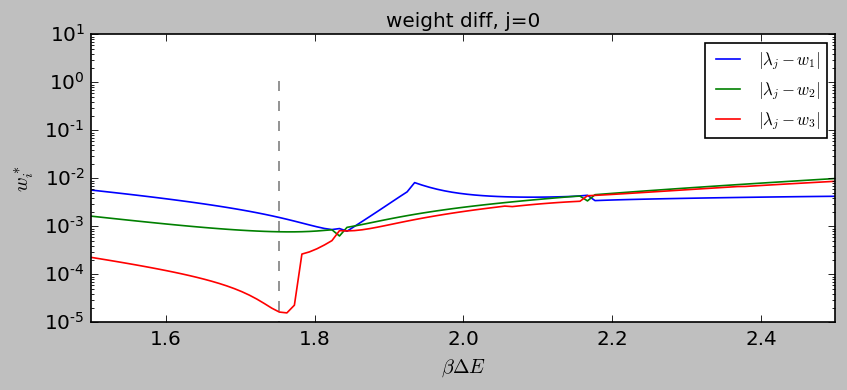

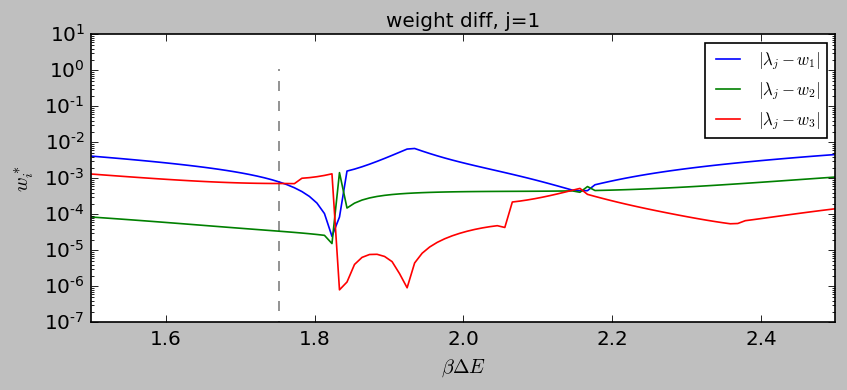

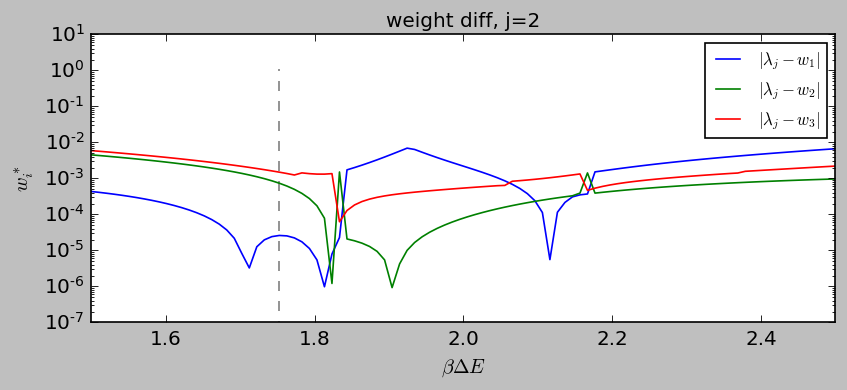

In [72]:
for j in range(len(state_range)): 
    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[0,:]), '-', label=r"$|\lambda_j-w_1|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[1,:]), '-', label=r"$|\lambda_j-w_2|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[2,:]), '-', label=r"$|\lambda_j-w_3|$")

    ax1.legend(fontsize=10)
    ax1.set_ylabel(r"$w^*_i$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.set_yscale("log")
    ax1.set_title("weight diff, j="+str(j), fontsize=12)
    ax1.set_xlim(left=beta_list_fine[0]*levelSpace, right=beta_list_fine[-1]*levelSpace)

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_diff"+str(j)+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight')
    print(filename)

#### Compute coupling matrix (AGP)

In [45]:
def readInWF(filename_base, filename_base_s, beta):     
    
    filename_weights = filename_base + str(round(beta,6)) + ".txt"
    filename_states = filename_base_s + str(round(beta,6)) + ".txt"
    
    ## Read the weights and states from text files
    w_alph = np.loadtxt("diagW/"+filename_weights, dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/"+filename_states, dtype = "complex", delimiter=',', comments='#')
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.1
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+sigma_x,dx)), np.arange(0,x1_max+dx+sigma_x,dx)), 3)
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    if n_x1q**2 != len(psi_alph[:,1]): 
        print("error in reading")
    return x1_range_q, w_alph, psi_alph

# beta_list_fine = np.linspace(1.0, 3.0, 50) / levelSpace

# filename_base = "SingleT_2dseparable/JJ_CM_weights_nearMore"
# filename_base_s = "SingleT_2dseparable/JJ_CM_states_nearMore"

filename_base = "SingleT_2dasym/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_2dasym/JJ_CM_states_nearMore"

beta = beta_list_fine[3]
# print(filename_base, beta)
x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)

print(np.shape(w_alph), np.shape(psi_alph), np.shape(x_range_q))

(6561,) (6561, 10) (81,)


##### Plot Eigenstates (Check)

(81, 81)


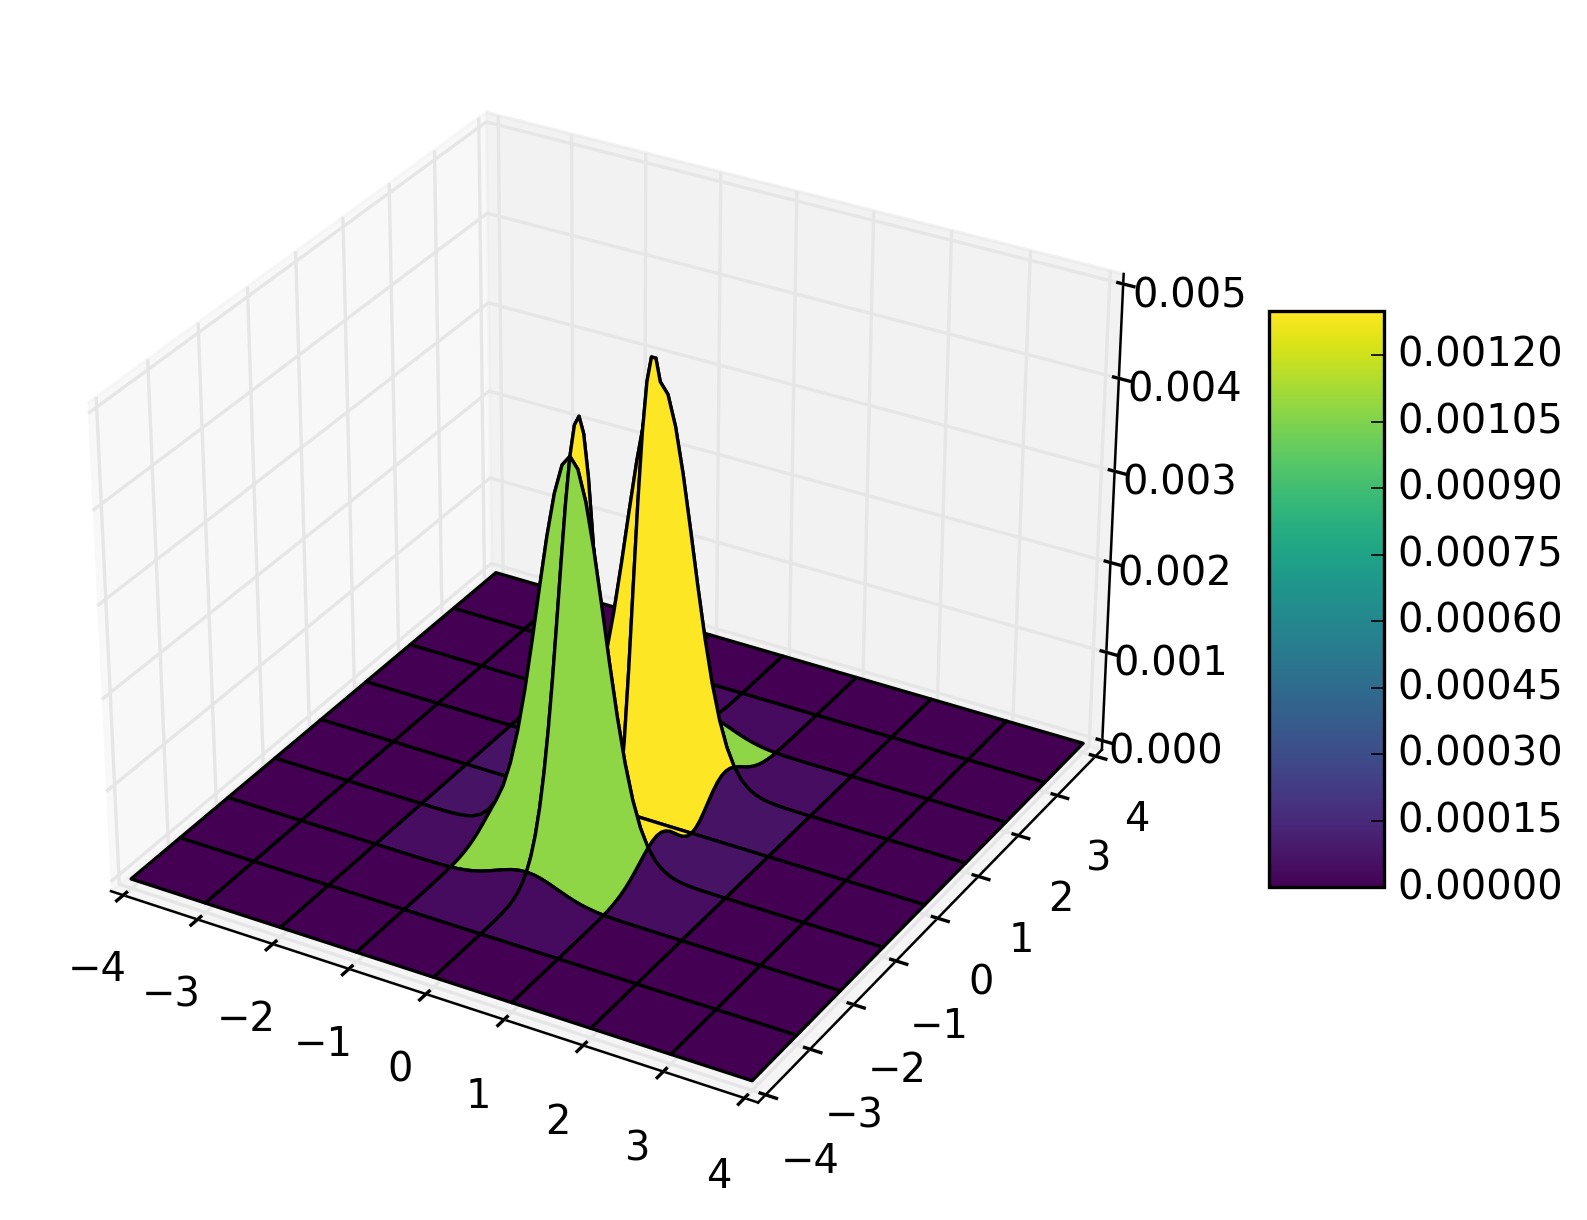

In [46]:
##Plot eigenstates
f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
ax1.plot(x_range_q, np.real(psi_alph[0:-1:len(x_range_q), 0]), label="n=0, y="+str(x_range_q[0])+"")
for offset in [10,20,30,40]:
    ax1.plot(x_range_q, np.real(psi_alph[offset:-offset:len(x_range_q),0]), label="n=0, y="+str(x_range_q[offset])+"")
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$\psi_n$")
ax1.set_xlabel(r"$x$")
ax1.set_xlim([x_range_q[0], x_range_q[-1]])
plt.close()

## Plot full 2d eigenstates
i=1
psi_alph1 = np.reshape(psi_alph[:,i], (-1,len(x_range_q))); print(np.shape(psi_alph1))
fig = plt.figure(figsize=(10,6), dpi=240, frameon=False)
ax1 = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(x_range_q,x_range_q)

surf1 = ax1.plot_surface(X, Y, np.abs(psi_alph1)**2, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

##### Compute AGP coupling matrix elements

In [7]:
## Compute matrix components 

def V(x): 
    a=float(a_Range[0])
    return omega/4 * (x**4 - a*x)

def M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta): 
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    W1_psi = np.dot(d_beta_W, psi_alph[:,k])
    A_n = np.vdot(W1_psi, psi_alph[:,j]) / Zx
    
    return np.abs(A_n)**2 / (np.real(w_alph[j] - w_alph[k])**2)

n_Max = 10
Coupling_M = np.zeros((n_Max, n_Max))

d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
for x1_i, x1 in enumerate(x_range_q): 
    xi = x1 - x_range_q
    x_x = (x1 + x_range_q) / 2
    d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                        * np.exp((-m*xi**2)/(2.*beta*eps**2)-beta*V(x_x))
    
for j in range(2,n_Max): 
    for k in range(n_Max): 
        if j!=k: 
            Coupling_M[j,k] = M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = M_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)


NameError: name 'a_Range' is not defined

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (8,6), dpi=50, frameon=False)
im = ax1.matshow(Coupling_M, cmap=plt.cm.jet)
# im = ax1.matshow(np.log10(Coupling_M, where=Coupling_M!=0), cmap=plt.cm.jet)

# Add a colorbar
fig.colorbar(im, ax=ax1)


In [69]:
## Computing coupling vs. beta
n_Max = 10
Coup_M_beta = np.zeros((n_Max, n_Max,len(beta_Range)))

beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
a_q = a_Range[0]
for beta_i, beta in enumerate(beta_Range): 
    print(beta_i, end=" ")
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
    
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    
    Coupling_M = np.zeros((n_Max, n_Max))

    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                        * np.exp((-m*xi**2)/(2.*beta*eps**2)-beta*V(x_x))

    for j in range(n_Max): 
        for k in range(j+1,n_Max): 
            Coupling_M[j,k] = M_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = M_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)

    Coup_M_beta[:,:, beta_i] = Coupling_M[:,:]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Plots_W/JJ_CM_eps0.5_AGP_asym_0.png


Text(0.5, 1.0, '$a=0.0$')

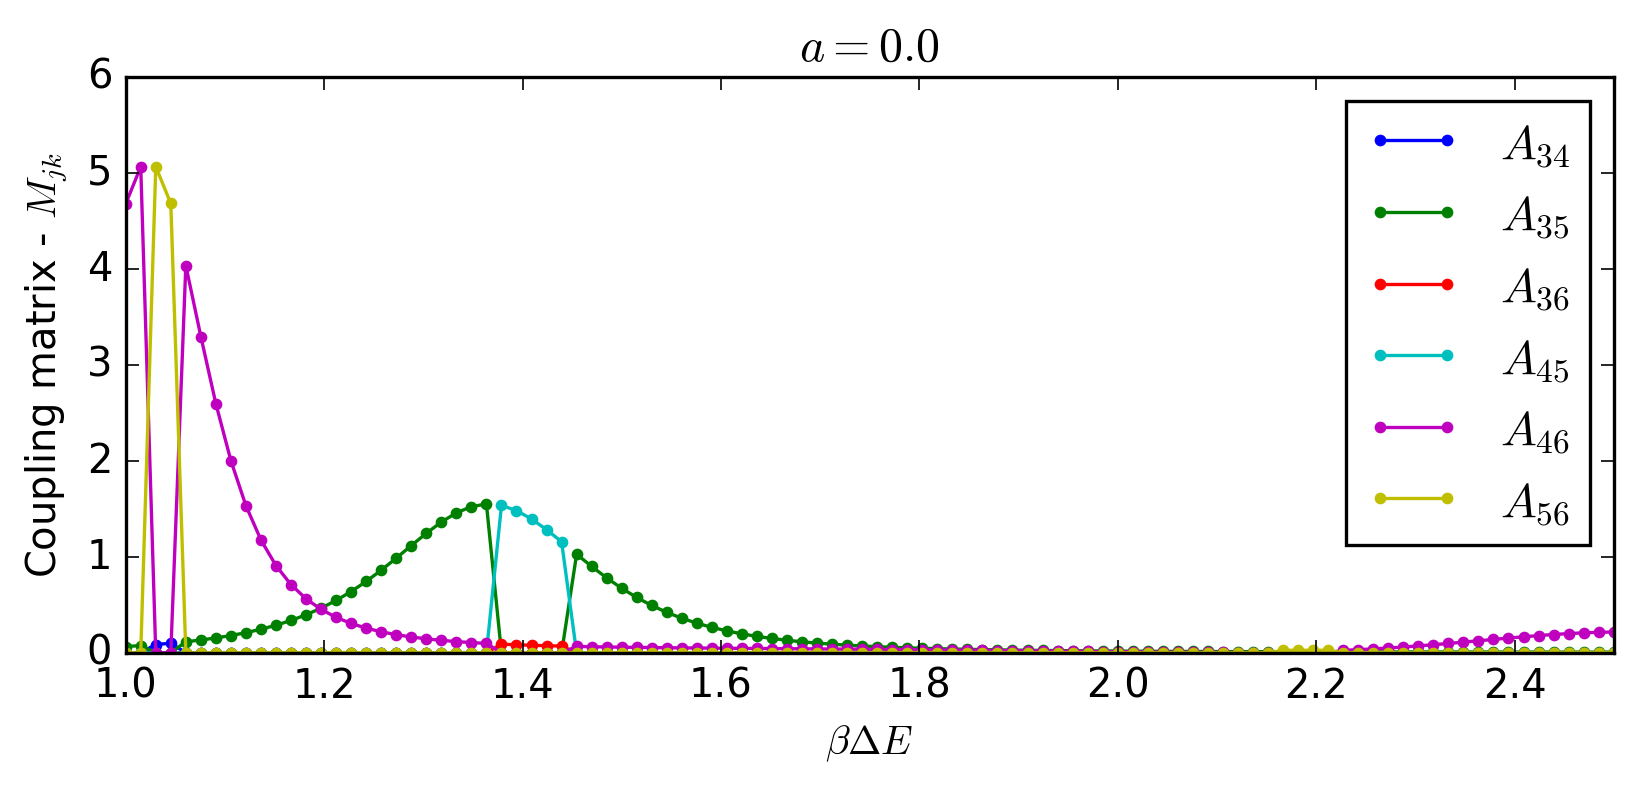

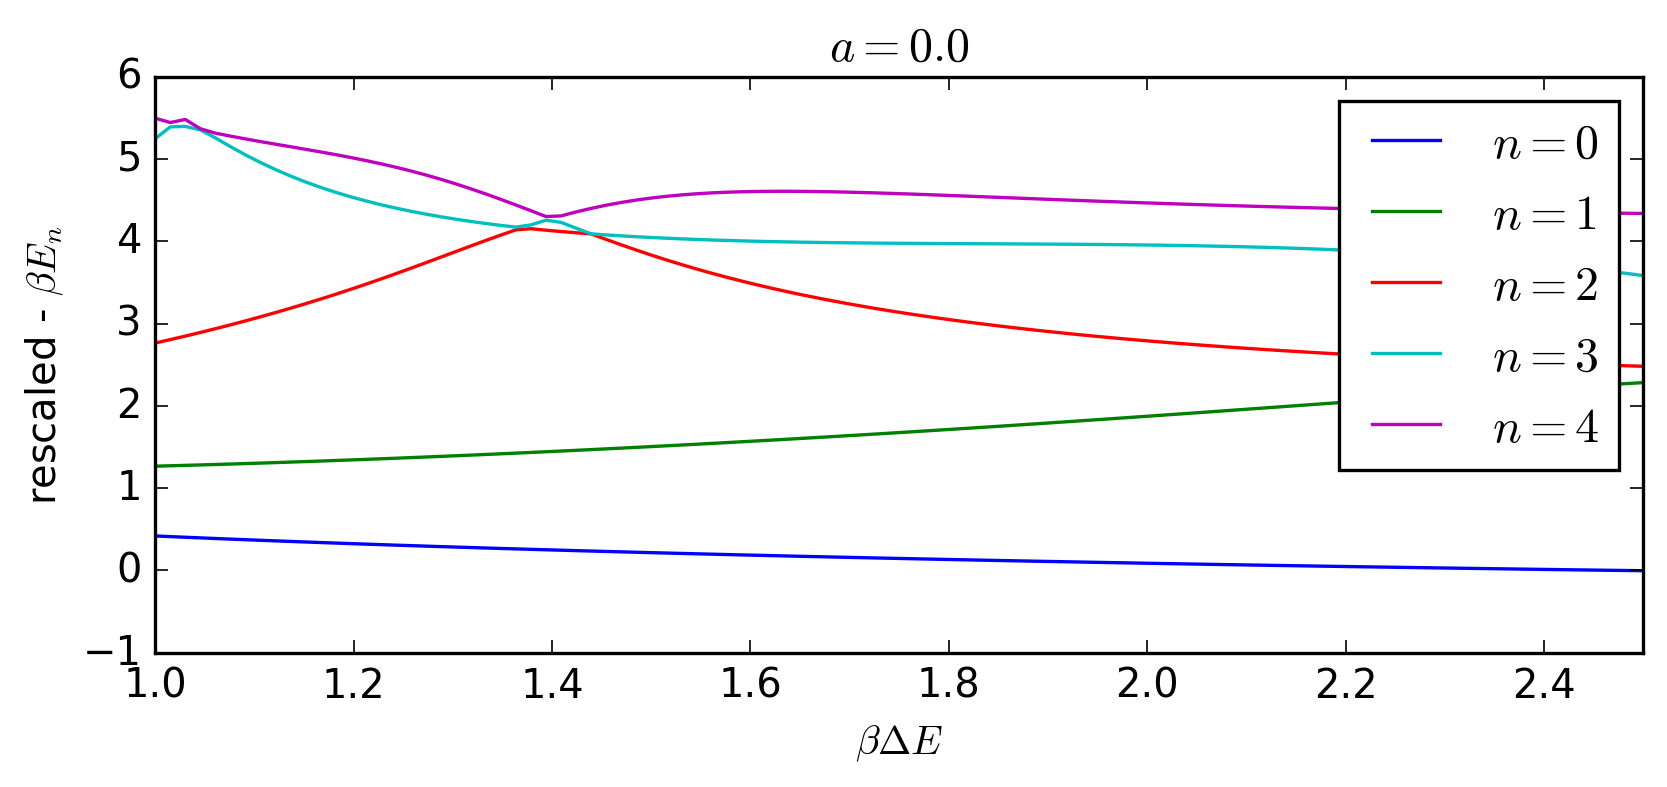

In [70]:
filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

for j in range(3,n_Max-3): 
    for k in range(j+1,n_Max-3): 
        ax2.plot(beta_list_fine*levelSpace, Coup_M_beta[j-1,k-1,:], ".-", label=r"$A_{"+str(j)+str(k)+"}$")
    
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"Coupling matrix - $M_{jk}$")
ax2.set_xlim([1, 2.5])
# ax2.set_ylim([-0.1,2])
ax2.set_title(r"$a="+str(float(a_q))+"$")
ax2.legend()
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_AGP_asym_"+ a_q +".png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
states_n = 5
for k in range(0, states_n):
    EigEnergies_re = np.zeros((len(beta_list_fine)))

    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list_fine[j_i][k]))

    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re, '-', label=r"$n="+str(k)+"$")
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax2.set_xlim([1, 2.5])
ax2.set_ylim([-1, 6])
ax2.legend()
ax2.set_title(r"$a="+str(float(a_q))+"$")

##### Repeating calc for all $a$

In [17]:
a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]

for a_q in a_Range: 
    Coup_M_beta = np.zeros((4,4,len(beta_Range)))

    beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
    print(a_q)
    
    for beta_i, beta in enumerate(beta_Range): 
        print(beta_i, end=" ")
        filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
        filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"

        x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)

        n_Max = 5
        Coupling_M = np.zeros((n_Max, n_Max))

        for j in range(n_Max): 
            for k in range(j,n_Max): 
                if j!=k: 
                    Coupling_M[j,k] = M_nm(j,k, x_range_q, w_alph, psi_alph, beta)
                    Coupling_M[k,j] = M_nm(k,j, x_range_q, w_alph, psi_alph, beta)

        Coup_M_beta[:,:, beta_i] = Coupling_M[1:,1:]

    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    w_alph_list_fine = readInNew_all_a(filename_base, beta_list_fine)

    f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

    for j in range(1,n_Max): 
        for k in range(j+1,n_Max): 
            ax2.plot(beta_list_fine*levelSpace, Coup_M_beta[j-1,k-1,:], ".-", label=r"$A_{"+str(j)+str(k)+"}$")

    ax2.set_xlabel(r"$\beta \Delta E$")
    ax2.set_ylabel(r"Coupling matrix - $M_{jk}$")
    ax2.set_xlim([1, 2.5])
    ax2.set_ylim([-0.1,2])
    ax2.set_title(r"$a="+str(float(a_q))+"$")
    ax2.legend()
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_AGP_asym_"+ a_q +".png"
    f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)
    plt.close()

0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_0.png
1e-2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_1e-2.png
5e-2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Plots_W/JJ_CM_eps0.5_AGP_asym_5e-2.png
1e-1

#### Norm of AGP

$$ \text{Norm}[n] = \sum_j \frac{ |\langle j| \partial_\beta W | n\rangle|^2 }{ (w_j - w_n)^2 }$$ 

In [72]:
# def V(x,y):
#     return omega/4 * (x**2 + y**2 + x**2*y**2)
#     return omega/4 * (x**2 + 2.5*y**2 + x**2*y**2)

## Computing coupling vs. beta

n_Max = 10
A_n = np.zeros((n_Max, len(beta_Range))); 
A_n_weight = np.zeros((len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)
norm_2 = np.zeros(len(beta_Range))

for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
    
    filename_base = "SingleT_2dasym/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_2dasym/JJ_CM_states_nearMore"
    
#     filename_base = "SingleT_2dseparable/JJ_CM_weights_nearMore"
#     filename_base_s = "SingleT_2dseparable/JJ_CM_states_nearMore"

    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /= np.sum(w_alph)
    norm_2[beta_i] = np.abs(np.sum( np.power(w_alph, 2) ))
    
    Zx = np.sum(np.sum(np.exp(-beta * (V(x_range_q, x_range_q)))))
    n_xq = len(x_range_q)
    d_beta_W = np.zeros((n_xq**2,n_xq**2),dtype=complex)
    
#     for i in range(n_xq):
#         for j in range(n_xq): 
#             for k in range(n_xq): 
#                 for l in range(n_xq): 
#                     c_1 = n_xq * i + j
#                     c_2 = n_xq * k + l
#                     x_x = (x_range_q[i]+x_range_q[j])/2
#                     xi_x = x_range_q[i]-x_range_q[j]
#                     y_y = (x_range_q[k]+x_range_q[l])/2
#                     xi_y = x_range_q[k]-x_range_q[l]
#                     d_beta_W[c_1,c_2] = ((m*(xi_x**2+xi_y**2))/(2.*beta**2*eps**2)-V(x_x,y_y)) \
#                                                 * np.exp((-m*(xi_x**2 + xi_y**2))/(2.*beta*eps**2)) * np.exp(-beta*V(x_x,y_y))
    
    for i in range(n_xq):
        for k in range(n_xq): 
            c_1 = n_xq * i
            c_2 = n_xq * k
            x_x = (x_range_q[i]+x_range_q)/2
            xi_x = x_range_q[i]-x_range_q
            y_y = (x_range_q[k]+x_range_q)/2
            xi_y = x_range_q[k]-x_range_q
            d_beta_W[c_1:c_1+n_xq,c_2:c_2+n_xq] = ((m*(xi_x**2+xi_y**2))/(2.*beta**2*eps**2)-V(x_x,y_y)) \
            * np.exp((-m*(xi_x**2 + xi_y**2))/(2.*beta*eps**2)) * np.exp(-beta*V(x_x,y_y))

    for j in range(n_Max): 
        dbW_psi = np.dot(d_beta_W,psi_alph[:,j])
        for k in range(n_Max): 
            if j!=k: 
#                 A_n[j,beta_i]+= np.abs(np.vdot(psi_alph[:,k],dbW_psi))**2 / np.real(w_alph[j] - w_alph[k])**2 / Zx**2
                A_n[j,beta_i]+= w_alph[j]**2 * np.vdot(psi_alph[:,k],dbW_psi)**2/np.real(w_alph[j] - w_alph[k])**2
    
    A_n_weight[beta_i] += np.sum( beta**2 * np.real(w_alph[:n_Max]) * np.abs(A_n[:,beta_i]) )
    
    entropy[beta_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))

0 

<ipython-input-72-819f62e14cc5>:59: ComplexWarning: Casting complex values to real discards the imaginary part
  A_n[j,beta_i]+= w_alph[j]**2 * np.vdot(psi_alph[:,k],dbW_psi)**2/np.real(w_alph[j] - w_alph[k])**2


1 2 3 4 5 

KeyboardInterrupt: 

In [48]:
A_n_weight = np.zeros((len(beta_Range)))
for beta_i, beta in enumerate(beta_Range):  
#     for j in range(n_Max): 
    A_n_weight[beta_i] += np.sum(np.real(w_alph[:n_Max])**2 * np.abs(A_n[:,beta_i])**2) 

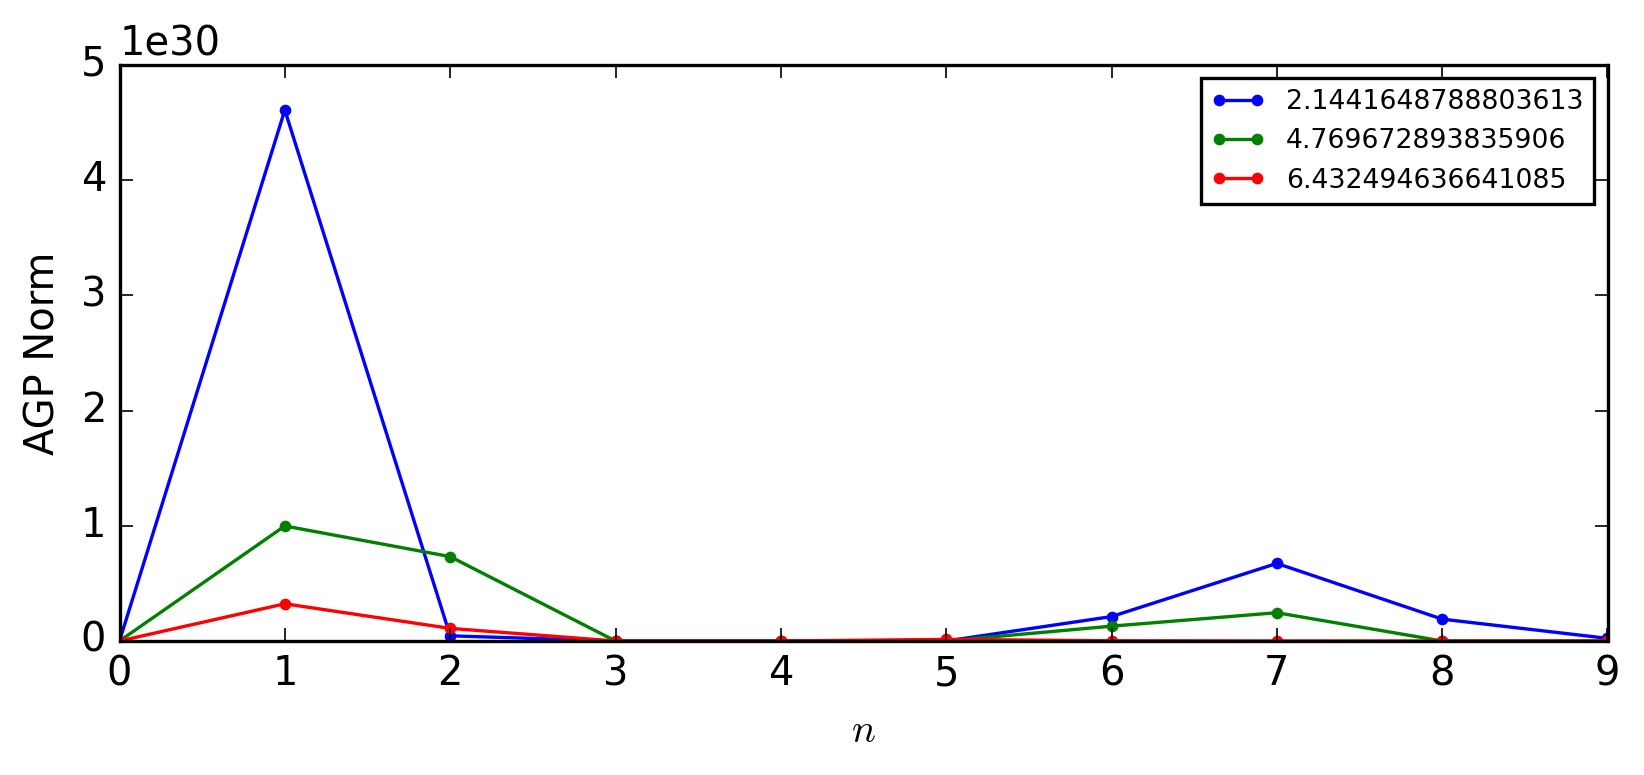

In [49]:
f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

for i in [0,30,-1]: 
    ax2.plot(A_n[:,i], '.-', label=beta_Range[i])

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"AGP Norm")
ax2.legend(fontsize=8)
# ax2.set_title(r"$a="+str(float(a_q))+"$")
# filename = "Plots_W/CM_eps"+str(eps)+"_AGPnorm_asym_"+ a_q +".png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
# print(filename)


Text(0, 0.5, 'Entropy, $S_2 = -\\log \\sum_n |w_n|^2$')

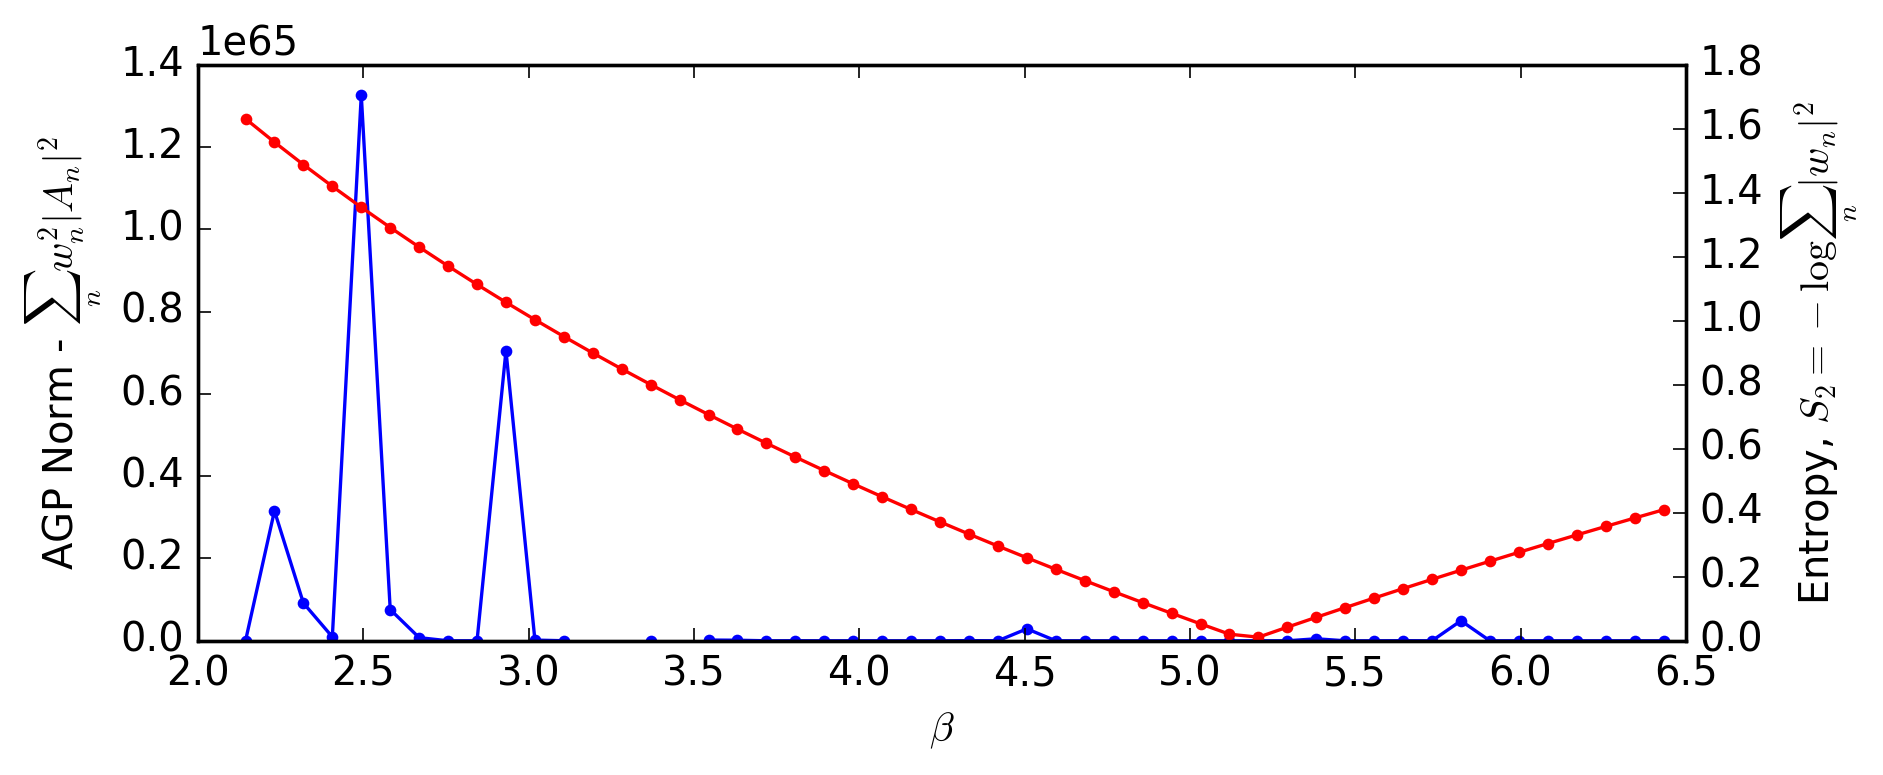

In [50]:
f, (ax) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

ax.plot(beta_Range, A_n_weight/norm_2, '.-')    
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"AGP Norm - $\sum_n w_n^2 |A_n|^2$")
# ax.set_title(r"$a="+str(float(a_q))+"$")

ax2 = ax.twinx()
ax2.plot(beta_Range, np.abs(entropy), 'r.-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
# filename = "Plots_W/CM_eps"+str(eps)+"_AGPnorm_weighted_asym_"+ a_q +".png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
# print(filename)


##### Contribution from individual terms

In [76]:
n_Max = 10
A_nm = np.zeros((n_Max, n_Max, len(beta_Range))); 

beta_i = 10
beta = beta_Range[beta_i]

filename_base = "SingleT_2dasym/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_2dasym/JJ_CM_states_nearMore"
# filename_base = "SingleT_2dseparable/JJ_CM_weights_nearMore"
# filename_base_s = "SingleT_2dseparable/JJ_CM_states_nearMore"

for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /= np.sum(w_alph)

    Zx = np.sum(np.sum(np.exp(-beta * (V(x_range_q, x_range_q)))))
    n_xq = len(x_range_q)
    d_beta_W = np.zeros((n_xq**2,n_xq**2),dtype=complex)

    for i in range(n_xq):
        for j in range(n_xq): 
            for k in range(n_xq): 
                for l in range(n_xq): 
                    c_1 = n_xq * i + j
                    c_2 = n_xq * k + l
                    x_x = (x_range_q[i]+x_range_q[j])/2
                    xi_x = x_range_q[i]-x_range_q[j]
                    y_y = (x_range_q[k]+x_range_q[l])/2
                    xi_y = x_range_q[k]-x_range_q[l]
                    d_beta_W[c_1,c_2] = ((m*(xi_x**2+xi_y**2))/(2.*beta**2*eps**2)-V(x_x,y_y)) \
                                                * np.exp((-m*(xi_x**2 + xi_y**2))/(2.*beta*eps**2)) * np.exp(-beta*V(x_x,y_y))

    for j in range(n_Max): 
        dbW_psi = np.dot(d_beta_W,psi_alph[:,j])
        for k in range(n_Max): 
            if j!=k: 
                A_nm[j,k, beta_i]+= np.real(np.vdot(psi_alph[:,k],dbW_psi)**2/(w_alph[j] - w_alph[k])**2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

<ipython-input-145-c7984e697064>:9: RuntimeWarning: divide by zero encountered in log10
  im = ax1.matshow(np.log10(A_nm1[:,:,beta_i]), cmap=plt.cm.jet)
/Users/thomastenzin/miniforge3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


4.332088224676649


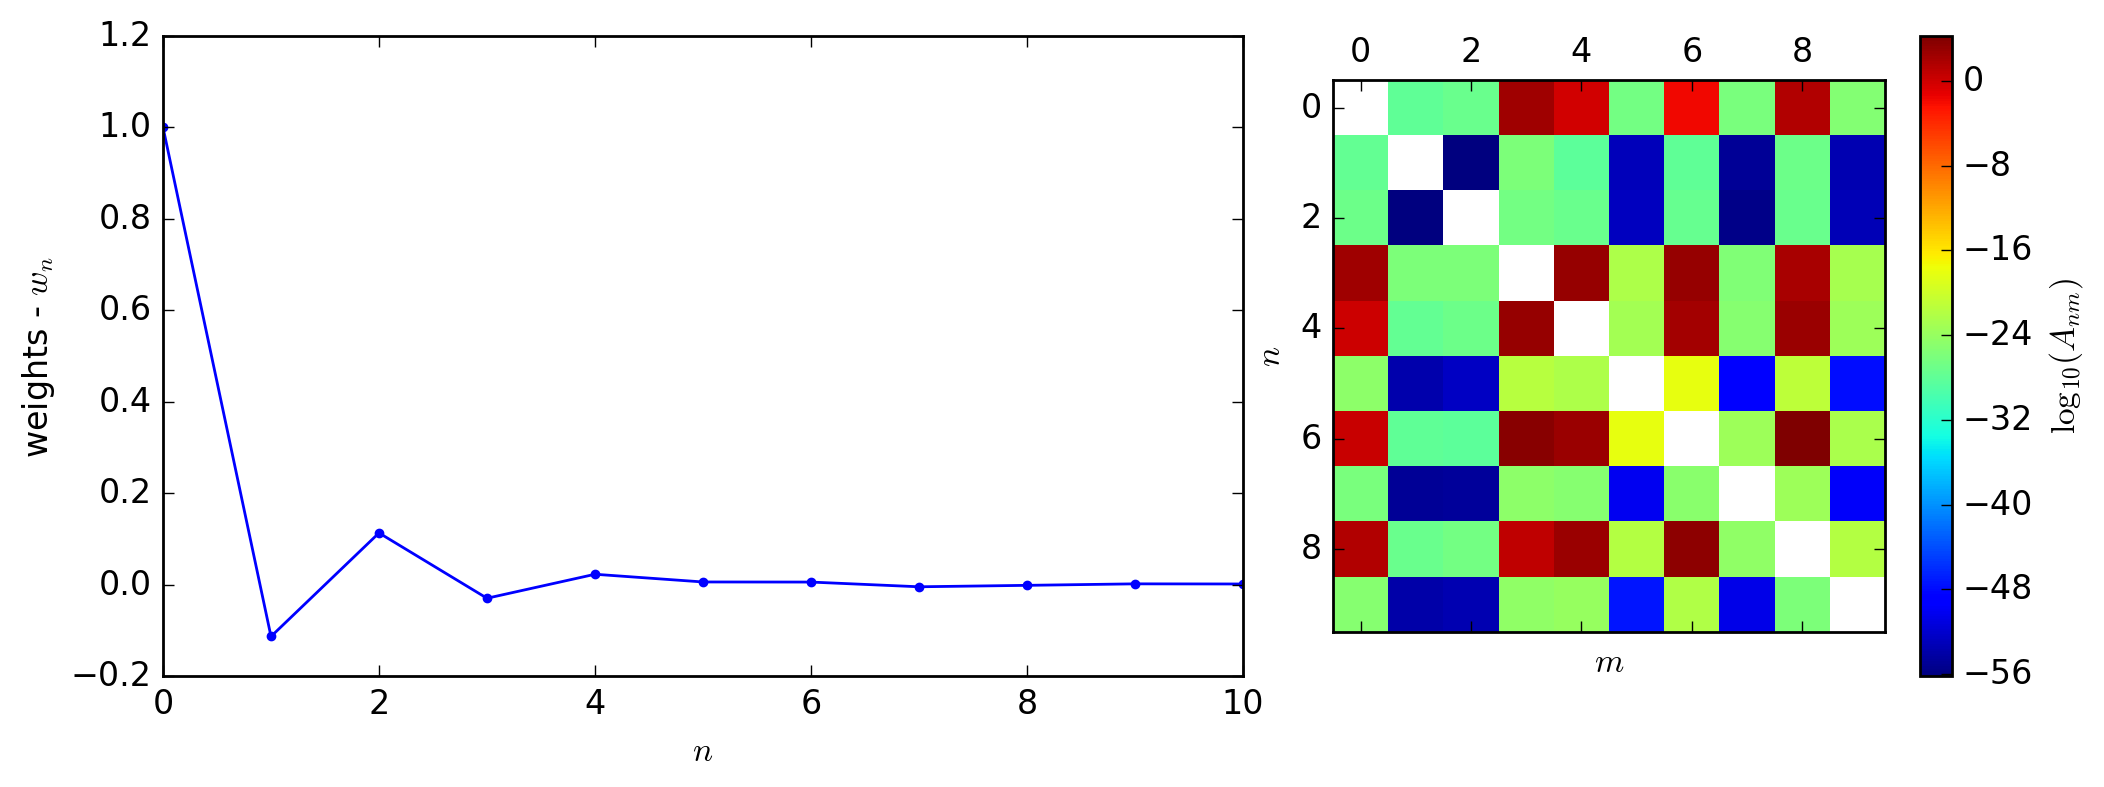

In [145]:
beta_i = 25
beta = beta_Range[beta_i]

fig = plt.figure(figsize = (12,4), dpi=200, frameon=False)
grid = plt.GridSpec(1, 5, wspace=0.3)
ax1 = plt.subplot(grid[0, 3:])
ax2 = plt.subplot(grid[0, :3])

im = ax1.matshow(np.log10(A_nm1[:,:,beta_i]), cmap=plt.cm.jet)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r"$\log_{10} (A_{nm})$")
ax1.set_ylabel(r"$n$")
ax1.set_xlabel(r"$m$")

filename_base = "SingleT_2dasym/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_2dasym/JJ_CM_states_nearMore"
x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
w_alph /= np.sum(w_alph)
ax2.plot(w_alph[:11], '.-')    
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"weights - $w_n$")

print(beta_Range[beta_i])

In [140]:
## Write the matrix to a text file
for beta_i, beta in enumerate(beta_Range): 
    filename = "diagW/SingleT_2dasym/JJ_CM_Anm_" +str(round(beta, 6))+ ".txt"
    listToStr = ','.join([str(elem) for elem in [m, omega, eps, beta]])
    np.savetxt(filename, A_nm[:,:,beta_i], delimiter=',', header=listToStr, comments='#')

In [144]:
n_Max = 10
A_nm1 = np.zeros((n_Max, n_Max, len(beta_Range))); 
## Reading the matrix from text file
for beta_i, beta in enumerate(beta_Range): 
    filename = "diagW/SingleT_2dasym/JJ_CM_Anm_" +str(round(beta, 6))+ ".txt"
    A_nm1[:,:,beta_i] = np.loadtxt(filename, delimiter=',', comments='#')

##### Summing terms to full metric

In [88]:
A_n = np.zeros((n_Max, len(beta_Range))); 
g_beta = np.zeros( len(beta_Range) )
entropy = np.zeros_like(beta_Range, complex)

for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
    filename_base = "SingleT_2dasym/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_2dasym/JJ_CM_states_nearMore"
    
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /= np.sum(w_alph)
    
    entropy[beta_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))
    
    for j in range(n_Max): 
        for k in range(n_Max): 
            A_n[j, beta_i] += A_nm[j,k, beta_i]
    g_beta[beta_i] += np.sum( beta**2 * np.real(w_alph[:n_Max]) * np.abs(A_n[:,beta_i]) )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Plots_W/CM_eps0.5_2dasym_AGPnorm_weighted.png


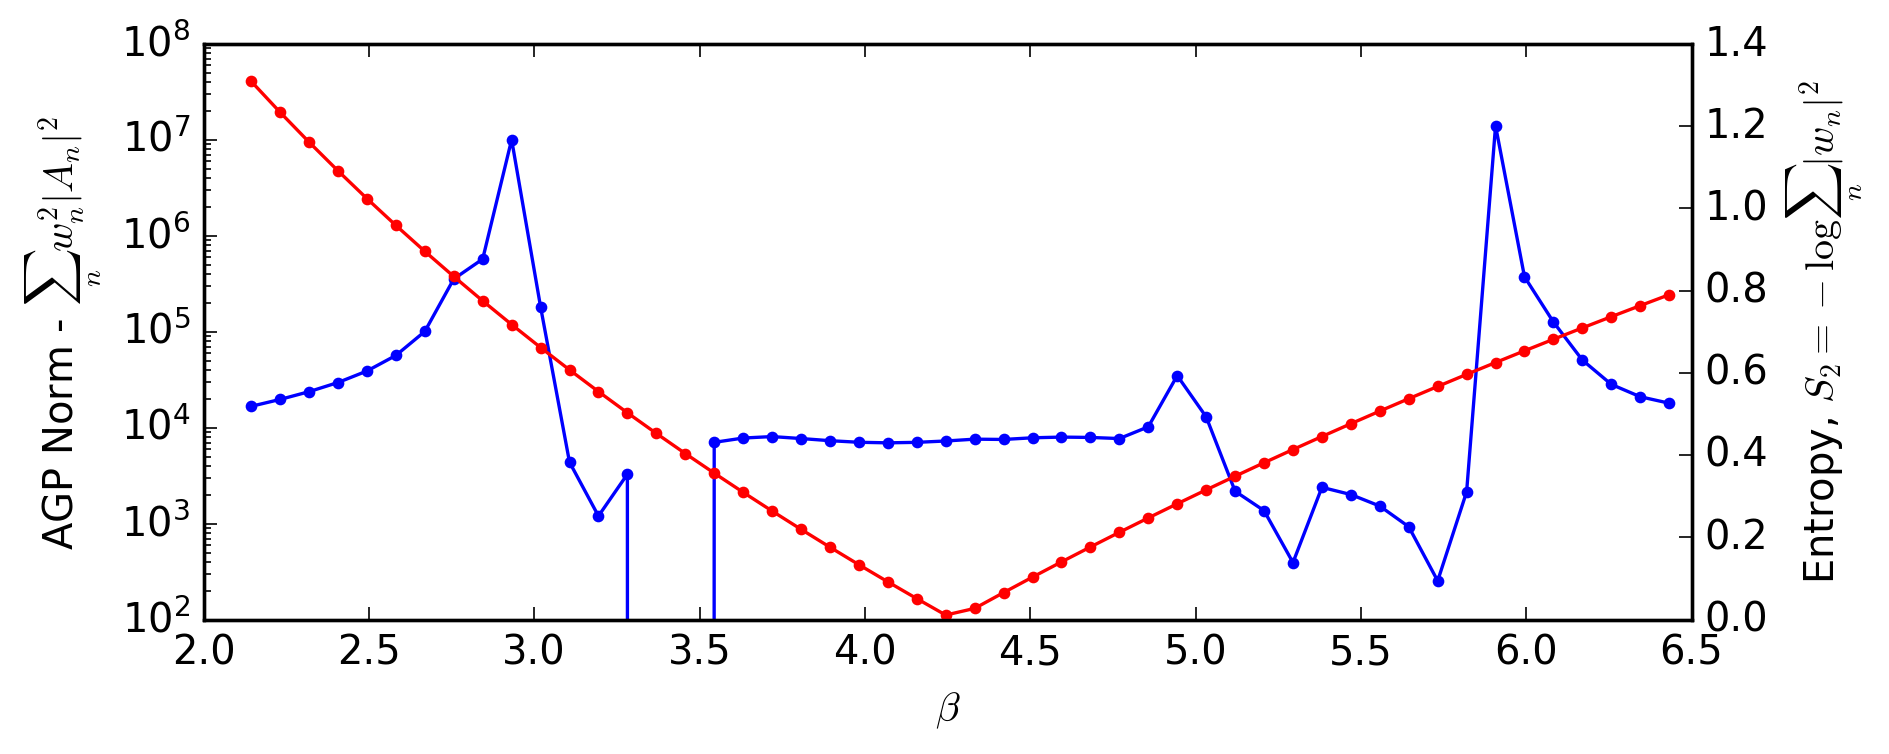

In [105]:
f, (ax) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

ax.plot(beta_Range, g_beta, '.-')    
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"AGP Norm - $\sum_n w_n^2 |A_n|^2$")
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(beta_Range, np.abs(entropy), 'r.-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_2dasym_AGPnorm_weighted.png"
f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)



In [96]:
print(g_beta)

[ 1.67341650e+04  1.97411872e+04  2.37777201e+04  2.96220825e+04
  3.90195208e+04  5.67044483e+04  1.00798215e+05  3.54802203e+05
  5.72375605e+05  1.00333970e+07  1.81953930e+05  4.38591081e+03
  1.20449024e+03  3.28476809e+03 -1.57593668e+05 -2.80081949e+05
  7.05192204e+03  7.81915435e+03  8.09856185e+03  7.72720959e+03
  7.33741329e+03  7.06328123e+03  6.96856514e+03  7.05232476e+03
  7.28441828e+03  7.61104640e+03  7.55751518e+03  7.86617428e+03
  7.99895629e+03  7.93214893e+03  7.72185340e+03  1.02347570e+04
  3.49443334e+04  1.30018674e+04  2.18327163e+03  1.37065994e+03
  3.94505030e+02  2.39654368e+03  2.01607963e+03  1.52946869e+03
  9.31467575e+02  2.54263900e+02  2.15068936e+03  1.39865579e+07
  3.73828265e+05  1.26344818e+05  5.07393801e+04  2.83133324e+04
  2.10477846e+04  1.80334846e+04]


#### Approx $W$ to few states

In [24]:
n_max_Range = np.arange(1, 6)

distances = np.zeros((len(n_max_Range),len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)

for n_max_i, n_max in enumerate(n_max_Range): 
    for j_i, j in enumerate(beta_Range): 
        w_alph = w_alph_list_fine[j_i]
        distances[n_max_i, j_i] = np.sum(np.abs(w_alph[2*n_max:])**2)

for j_i, j in enumerate(beta_Range):   
    w_alph = w_alph_list_fine[j_i]
    entropy[j_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))
    
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
for n_max_i, n_max in enumerate(n_max_Range): 
    ax1.plot(beta_Range*levelSpace, distances[n_max_i,:], label=r"$n_{max} = "+str(n_max_Range[n_max_i])+"$")
ax1.legend(fontsize=10)
ax1.set_ylabel(r"$Tr (W-W_1)^2 = \sum_{j=2n_{max}} |w_j|^2$")
ax1.set_xlabel(r"$\beta\Delta E$")
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(beta_Range*levelSpace, np.abs(entropy), 'k-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_GibbsCompare.png"
f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)



Plots_W/CM_eps0.5_2dasym_GibbsCompare.png


### Analysing the 2D mexican hat potential 

$$ V(x,y) = \frac{\omega}{4} (x^4 + y^4 - x^2y^2) $$

In [132]:
## Read from file
def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
        w_alph = np.loadtxt("diagW/SingleT_2dwells/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]]
    return weights_list

beta_list_fine = np.linspace(0.1, 4.0, 50) / levelSpace
w_alph_list_fine = readInNew("JJ_CM_weights_nearMore", beta_list_fine)

print("Found this many weights:", np.shape(w_alph_list_fine))

Found this many weights: (50, 600)


#### Weights and Energy spectrum

<ipython-input-112-27ba8a4e9f51>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  sum_check[j_i] = np.sum(w_alph_list_fine[j_i])


Plots_W/JJ_CM_eps0.5_E_v_beta_2dwells.png


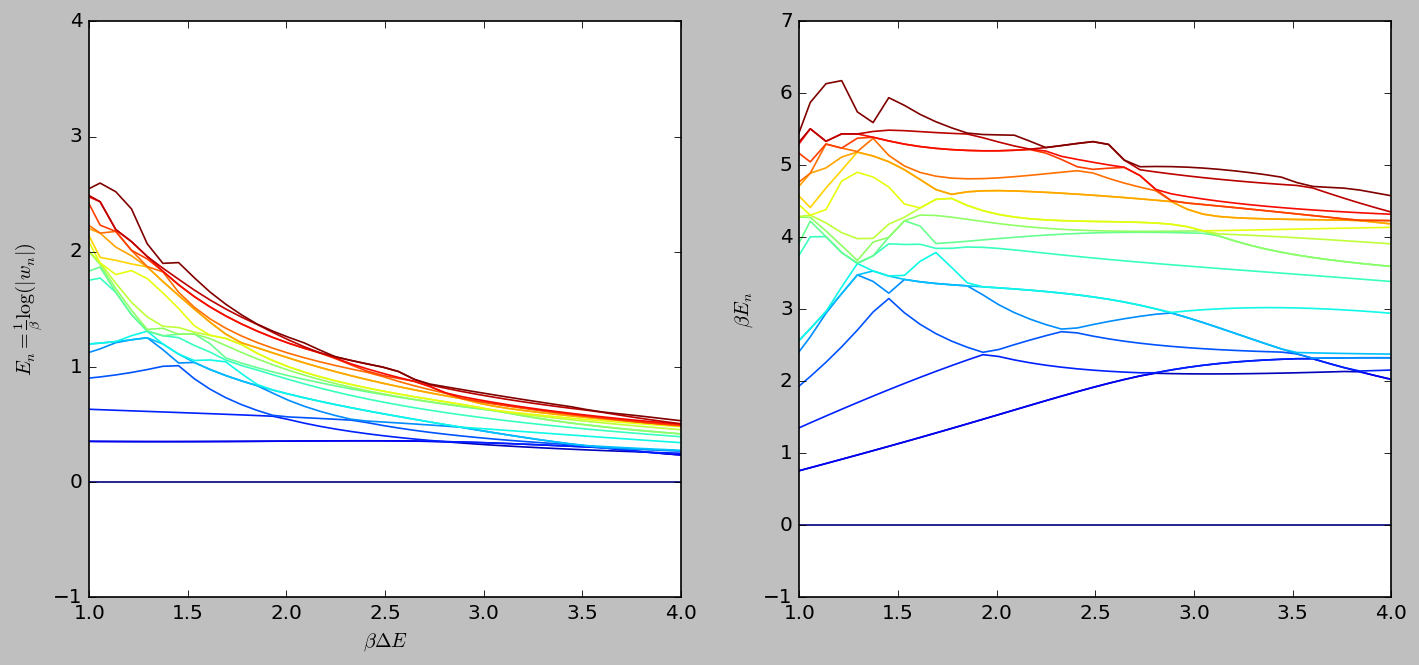

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6), dpi=120, frameon=True)
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 20

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))
sum_check = np.zeros(len(beta_list_fine))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i] + np.log(np.abs(w_alph_list_fine[j_i][0]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k])) + np.log(np.abs(w_alph_list_fine[j_i][0]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        sum_check[j_i] = np.sum(w_alph_list_fine[j_i])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))
    ax3.plot(beta_list_fine*levelSpace, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"$\beta E_n$")
ax3.set_ylabel(r"$w_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim([1,4])
ax1.set_ylim([0,4])
ax2.set_xlim([1,4])
ax3.set_xlim([1,4])
ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_E_v_beta_2dwells.png"
f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


Plots_W/JJ_CM_eps0.5_E_v_beta_2dwells_zoom.png


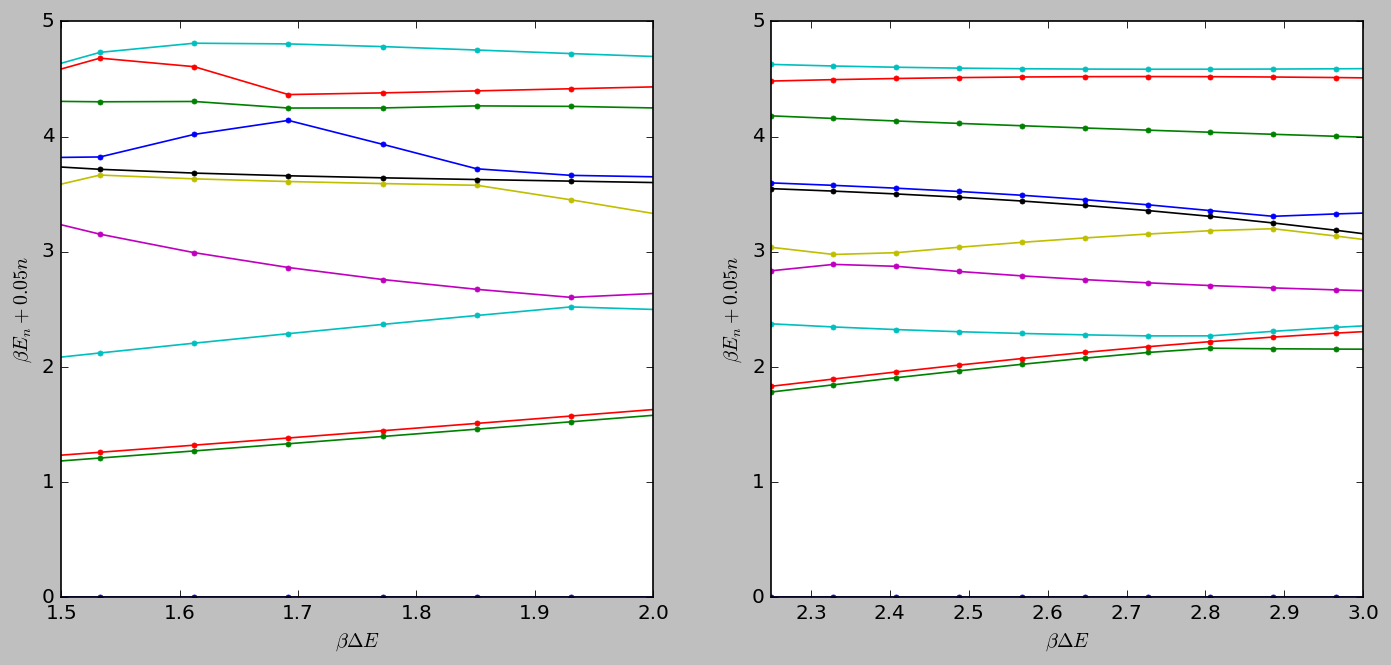

In [120]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6), dpi=120, frameon=True)

states_n = 11

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))
weights_toPlot = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i] - -np.log(np.abs(w_alph_list_fine[j_i][0]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k])) - -np.log(np.abs(w_alph_list_fine[j_i][0]))
        weights_toPlot[j_i, k] = np.real(w_alph_list_fine[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k]+0.05*k, '.-', label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k]+0.05*k, '.-', label="n="+str(k))

ax1.set_xlabel(r"$\beta \Delta E $")
ax2.set_xlabel(r"$\beta \Delta E $")
ax1.set_ylabel(r"$\beta E_n+ 0.05n$")
ax2.set_ylabel(r"$\beta E_n+ 0.05n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim([1.5,2])
ax2.set_xlim([2.25, 3])
# ax1.set_ylim(-0.1,4)
# ax2.set_ylim(-0.1,4)
# ax1.legend(fontsize=9)

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_E_v_beta_2dwells_zoom.png"
f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

Plots_W/JJ_CM_eps0.5_E_v_beta_2dwells_zoom.png


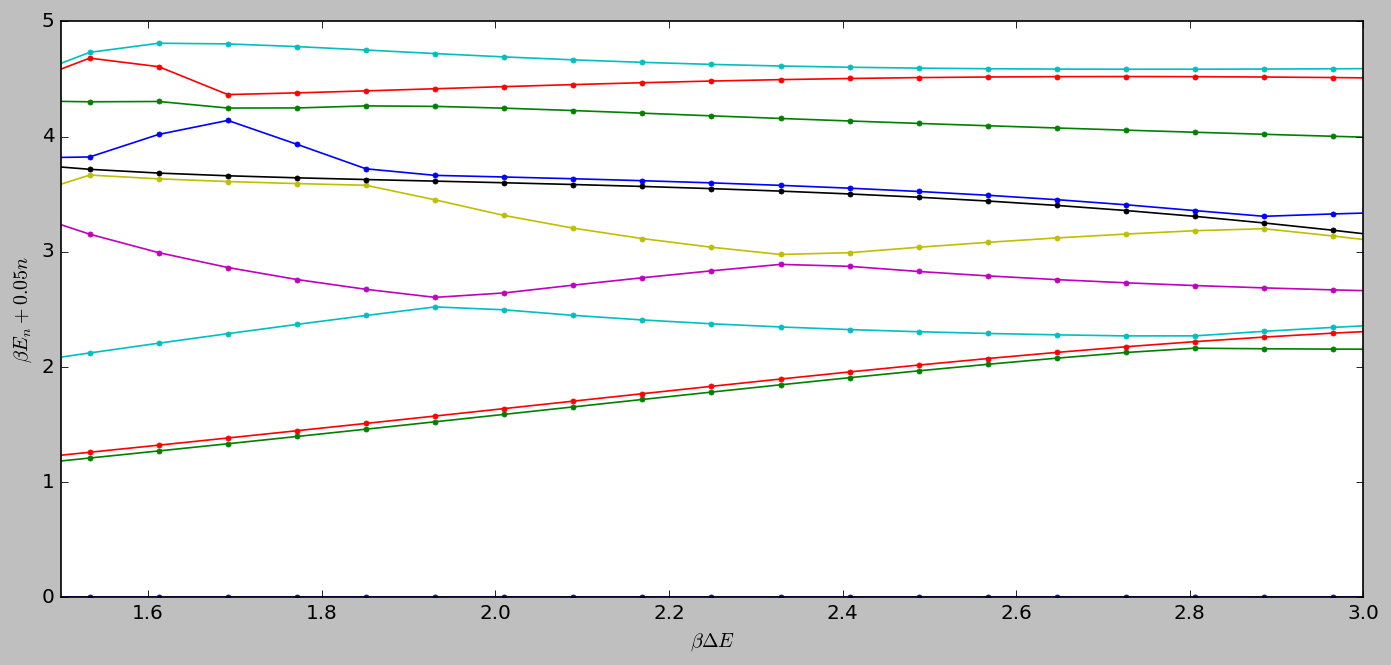

In [121]:
f, (ax1) = plt.subplots(1, 1, figsize = (14,6), dpi=120, frameon=True)

states_n = 11

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_list_fine), states_n))
EigEnergies_re = np.zeros((len(beta_list_fine), states_n))

for j_i, j in enumerate(beta_list_fine): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i] - -np.log(np.abs(w_alph_list_fine[j_i][0]))/beta_list_fine[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k])) - -np.log(np.abs(w_alph_list_fine[j_i][0]))
        
for k in range(0, states_n):
    ax1.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k]+0.05*k, '.-', label="n="+str(k))
    ax2.plot(beta_list_fine*levelSpace, EigEnergies_re[:,k]+0.05*k, '.-', label="n="+str(k))

ax1.set_xlabel(r"$\beta \Delta E $")
ax1.set_ylabel(r"$\beta E_n+ 0.05n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim([1.5,3])

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_E_v_beta_2dwells_zoom.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

#### Weights at given T

In [114]:
f, ax1 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

for beta_i, beta in enumerate(beta_list_fine):
    if 10 < beta_i < 50 and beta_i%5==0:
        ax1.plot(weights_toPlot[beta_i, 0:10], '.-', label=str(beta*levelSpace))
ax1.plot(np.arange(0,10), 0*np.arange(0,10), 'k--')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$w_n$")
ax1.legend(fontsize=10)
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_weights_quad.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 

#### Entropy

Plots_W/JJ_CM_eps0.5_entropy_2dwells.png
minimums: [32 34 34 34 34 34] [2 2 2 2 2 2]
vN: 23 2.646938775510204


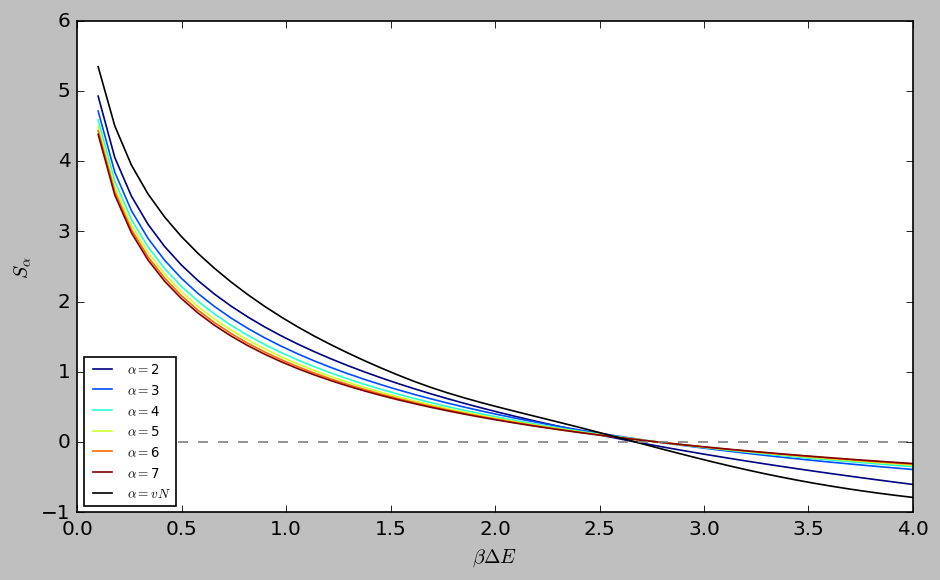

In [133]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)

powerRange = np.arange(2, 8, 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
    ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '-', color=colors[power_i],
             label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '-', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
# ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(fontsize=8, loc=3)
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_2dwells.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)
print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)


## Older analysis code (in case needed) 

In [23]:
## Read from file
def readInWF_single(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort states/weights by increasing energy
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.append(np.flip(-1*np.arange(0,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx))
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 

    return x1_range_q, sorted_psi_alph

def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
        w_alph = np.loadtxt("diagW/SingleT/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]]
    return weights_list
    

# beta_list_fine1 = 10.**np.arange(0.2, 0.4, 0.0025) / levelSpace
# w_alph_list_fine1, params = readInWF("diagW/JJ_CM_weights_near.txt")

beta_list_fine = np.linspace(1.85, 2.05, 100) / levelSpace
w_alph_list_fine = readInNew("JJ_CM_weights_nearMore", beta_list_fine)

print("Found weights for this many beta:", np.shape(w_alph_list_fine))
print(len(beta_list_fine))


Found weights for this many beta: (100, 600)
100


In [11]:
j_s = [0, 59, 90]

f, ax1 = plt.subplots(1, 1, figsize = (6,5), dpi=120)
for beta_i in range(0,100,1):
    if beta_i in j_s: 
        ax1.plot(np.real(w_alph_list_fine[beta_i][:10]), '.-',
                 label ="$\\beta \Delta E$="+str(round(beta_list_fine[beta_i]*levelSpace, 4)))
        printString = np.real(w_alph_list_fine[beta_i][:10])
#         for t in printString: 
#             print("{:.6}".format(t))
#         print("--")
ax1.plot(np.arange(0,9), np.zeros(9), 'k--')
ax1.set_ylabel("$w_\\alpha$")
ax1.set_xlabel("$\\alpha$")
# ax1.legend(loc=1, fontsize=8)
f.tight_layout()
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_weightsNear.png"
# f.savefig(filename, dpi=200) 

# f, ax1 = plt.subplots(1, 1, figsize = (6,5), dpi=120)
# for beta_i in range(6,len(beta_list_fine)-5): 
#     ax1.plot(np.log(np.abs(np.real(w_alph_list_fine[beta_i][0:10]))), '.-',
#              label ="$w_\\alpha$, $\\beta \Delta E$="+str(round(beta_list_fine[beta_i]*levelSpace, 4)))
# ax1.set_ylabel(r"$\log(w_\alpha)$")
# ax1.set_xlabel("$\\alpha$")
# ax1.legend(loc=1, fontsize=6)
# f.tight_layout()

#### Compute entropy as $\alpha \to 1$

In [12]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)

# powerRange = np.arange(2, 10, 0.5)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
    ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '.-', color=colors[power_i],
             label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
ax1.plot(beta_list_fine*levelSpace, np.real(entropyV), '.-', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_list_fine*levelSpace, beta_list_fine*levelSpace*0, '--', color='gray')
ax1.plot(beta_list_fine*0+beta_list_fine[np.int(minS_point[1])]*levelSpace, np.linspace(-.1,.2,len(beta_list_fine)), '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.set_xlim(left=1.85, right=2.05)
ax1.legend(fontsize=8, loc=3)
ax1.set_xticks(beta_list_fine[::15]*levelSpace)
ax1.set_xticklabels(np.around(beta_list_fine[::15]*levelSpace, 3))
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropyNearMore_abs2_large.png"
# f.savefig(filename, dpi=200) 
print(filename)

print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace)


Plots_W/JJ_CM_eps0.5_entropyNearMore_abs2_large.png
minimums: [64. 64. 64. 64. 63. 63. 62. 59. 57. 58.] [1.97929293 1.97929293 1.97929293 1.97929293 1.97727273 1.97727273
 1.97525253 1.96919192 1.96515152 1.96717172]
vN: 55 1.9792929292929293


#### Quantifying the Zero-entropy 

vN: 55 1.961111111111111
Plots_W/JJ_CM_eps0.5_entropyNearMore_abs2_crossing.png


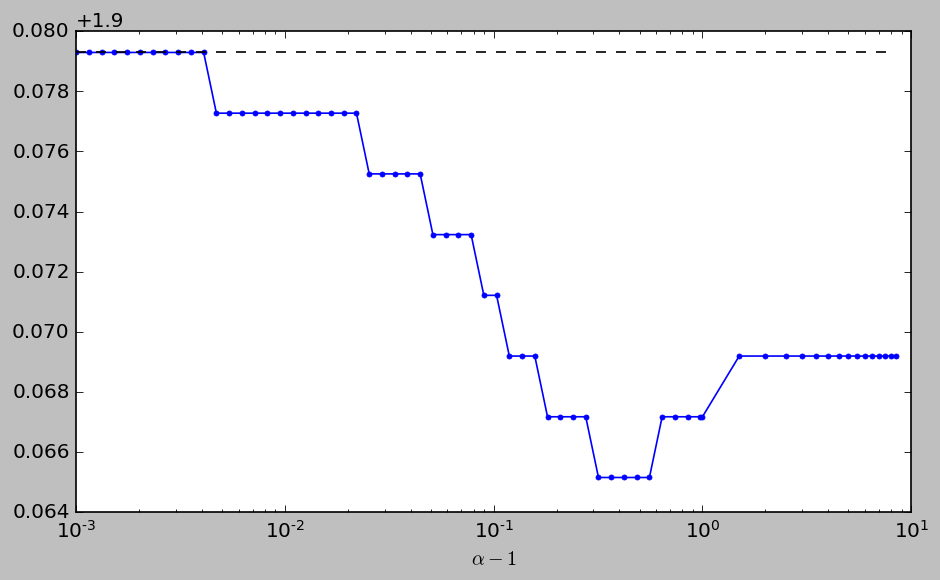

In [6]:
powerRange = np.append(1 + np.logspace(-3, -0.01, 50), np.arange(2, 10, 0.5))

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_list_fine, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list_fine[i], power) )))
#     ax1.plot(beta_list_fine*levelSpace, np.real(entropy2), '.-', color=colors[power_i],
#              label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_list_fine[int(minS_point[power_i])]*levelSpace

f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)
ax1.plot(powerRange-1, minS_beta, '.-', color='blue', label=r"$\alpha=vN$")

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))
print("vN:", np.argmin(np.abs(entropyV)), beta_list_fine[np.argmin(np.abs(entropyV))]*levelSpace)
ax1.plot(powerRange-1, powerRange*0+[beta_list_fine[np.argmin(np.abs(np.real(entropyV)))]*levelSpace], 
         'k--')

ax1.set_xlabel(r'$\alpha - 1$')
ax1.set_xlim(1e-3, 10)
ax1.set_xscale('log')
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropyNearMore_abs2_crossing.png"
# f.savefig(filename, dpi=200) 
print(filename)


Plots_W/JJ_CM_eps0.5_entropyNearMore_abs2_crossing_interp.png


/Library/Python/3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


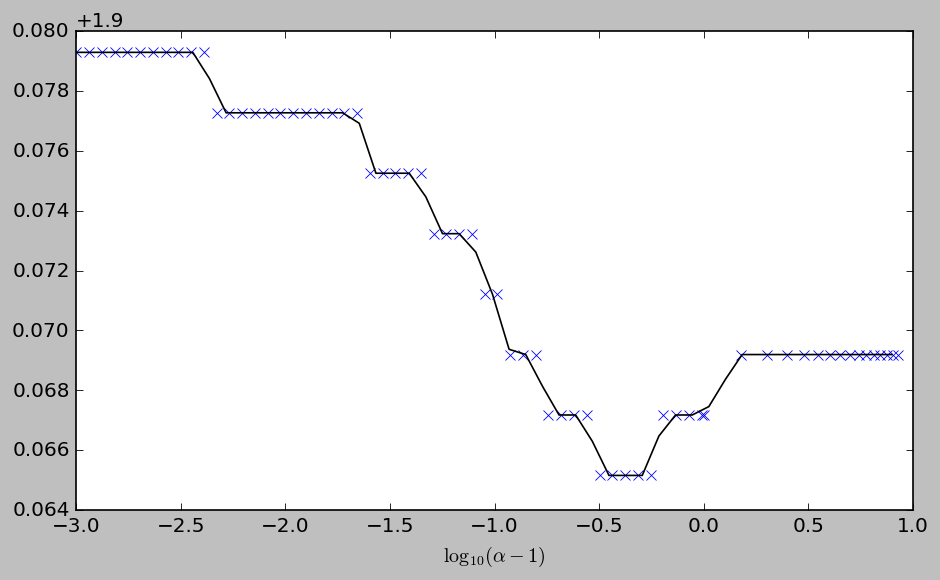

In [7]:
from scipy.interpolate import interp1d

f_interp1d = interp1d(np.log10(powerRange-1), minS_beta, kind='slinear')
x_interp1d = np.linspace(-3, 0.9, endpoint=True)

f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)
ax1.plot(np.log10(powerRange-1), minS_beta, 'x', color='blue')
ax1.plot(x_interp1d, f_interp1d(x_interp1d), '-', color='black')

entropyV = np.zeros_like(beta_list_fine, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list_fine[i]*np.log(w_alph_list_fine[i])))

ax1.set_xlabel(r'$\log_{10}(\alpha - 1)$')
ax1.set_xlim(-3, 1)
f.tight_layout()

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropyNearMore_abs2_crossing_interp.png"
# f.savefig(filename, dpi=200) 
print(filename)
f.show()

#### Expanding around maximally discrete point

Plots_W/JJ_CM_eps0.5_W_weights.png


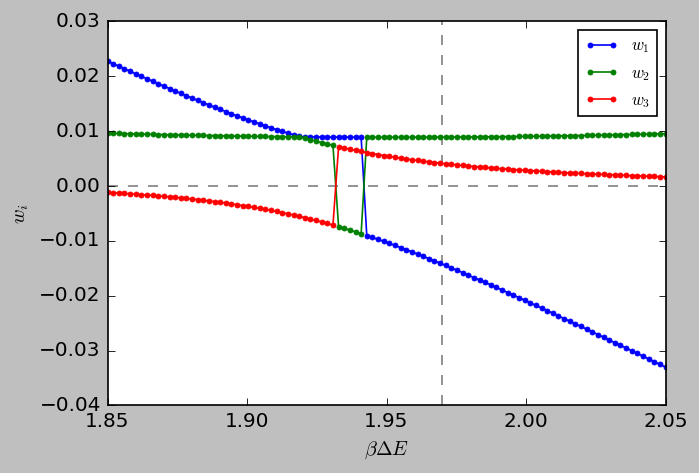

In [145]:
w_0_drift = np.zeros(beta_list_fine.size); w_0 = np.zeros(beta_list_fine.size)
w_1_drift = np.zeros(beta_list_fine.size); w_1 = np.zeros(beta_list_fine.size)
w_2_drift = np.zeros(beta_list_fine.size); w_2 = np.zeros(beta_list_fine.size)
w_3_drift = np.zeros(beta_list_fine.size); w_3 = np.zeros(beta_list_fine.size)

for beta_i, beta in enumerate(beta_list_fine): 
    w_0_drift[beta_i] = np.real(w_alph_list_fine[beta_i][0]) - 1
    w_1_drift[beta_i] = np.real(w_alph_list_fine[beta_i][1])
    w_2_drift[beta_i] = np.real(w_alph_list_fine[beta_i][2])
    w_3_drift[beta_i] = np.real(w_alph_list_fine[beta_i][3])
    w_0[beta_i] = np.real(w_alph_list_fine[beta_i][0])
    w_1[beta_i] = np.real(w_alph_list_fine[beta_i][1])
    w_2[beta_i] = np.real(w_alph_list_fine[beta_i][2])
    w_3[beta_i] = np.real(w_alph_list_fine[beta_i][3])

f, ax1 = plt.subplots(1, 1, figsize = (6,4), dpi=120, frameon=True)
ax1.plot(beta_list_fine*levelSpace, w_0_drift*0, '--', color='grey')
ax1.plot(beta_list_fine*0+1.97, np.linspace(-0.04,0.03,100), '--', color='grey')

ax1.plot(beta_list_fine*levelSpace, w_0_drift, '.-', label=r"$\delta_0$")
ax1.plot(beta_list_fine*levelSpace, w_1_drift, '.-', label=r"$\delta_1$")
ax1.plot(beta_list_fine*levelSpace, w_2_drift, '.-', label=r"$\delta_2$")
ax1.plot(beta_list_fine*levelSpace, w_3_drift, '.-', label=r"$\delta_3$")
ax1.legend(fontsize=10)

ax1.set_ylabel(r"$\delta_i$")
ax1.set_xlabel(r"$\beta \Delta E$")

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_delta.png"
# f.savefig(filename, dpi=200) 
print(filename)

#### Plotting log of the spectrum as a function of temperature. 

Is there level crossing?

Plots_W/JJ_CM_eps0.5_crossover_energiesVBeta_rescaled.png


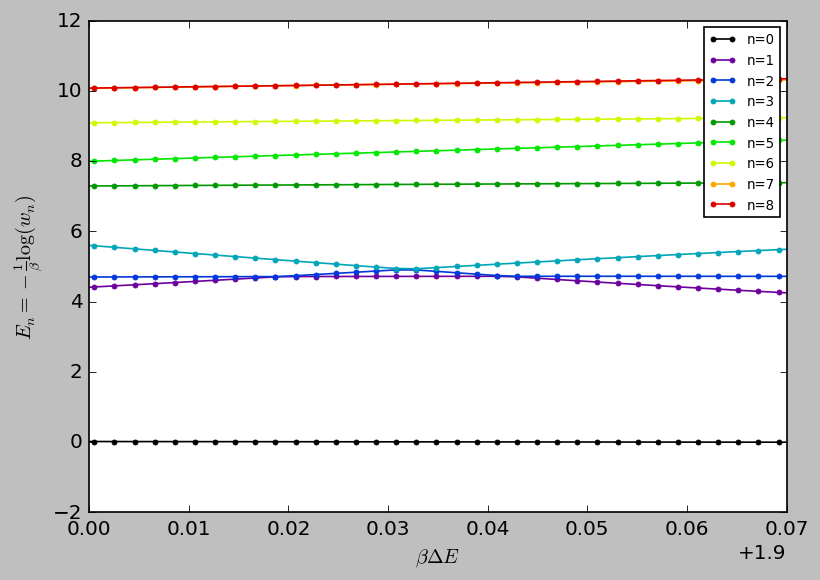

In [13]:
f, ax1 = plt.subplots(1, 1, figsize = (7,5), dpi=120, frameon=True)

plotRange = np.arange(0, 9)

color_list = pl.cm.nipy_spectral(np.linspace(0,0.9,plotRange.size))

EigEnergies = np.zeros((len(beta_list_fine),plotRange.size))

for k in plotRange: 
    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
    plt.plot(beta_list_fine*levelSpace, beta_list_fine*(EigEnergies[:,k]), '.-', color=color_list[k], 
             label="n="+str(k))

ax1.set_ylabel(r"$E_n = -\frac{1}{\beta}\log(w_n)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(loc=1, fontsize=8)
f.tight_layout()
ax1.set_xlim([1.90, 1.97])
# ax1.set_title(r"$w_n>0$: 'o'    $w_n<0$: 'x'")
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_crossover_energiesVBeta_rescaled.png"
# f.savefig(filename, dpi=200) 
print(filename)

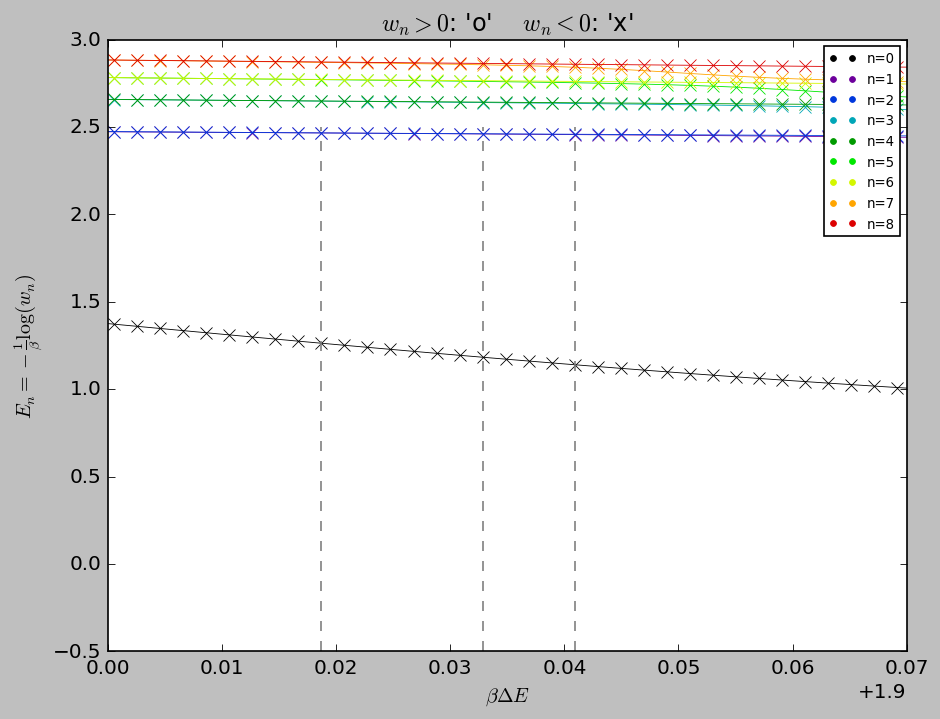

In [9]:
# Different signs of weights correspond to different marker
f, ax1 = plt.subplots(1, 1, figsize = (8,6), dpi=120, frameon=True)

plotRange = np.arange(0, 9)

color_list = pl.cm.nipy_spectral(np.linspace(0,0.9,plotRange.size))

# color_list=["black", 'blue', 'green', 'red', 'magenta', 'yellow']

EigEnergies = np.zeros((len(beta_list_fine),plotRange.size))

for k in plotRange: 
    EigEnergies_pos = []; beta_pos = []
    EigEnergies_neg = []; beta_neg = []
    for j_i, j in enumerate(beta_list_fine): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        if w_alph_list_fine[j_i][k] >= 0: 
            EigEnergies_pos += [-np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]]
            beta_pos += [beta_list_fine[j_i]*levelSpace]
        else: 
            EigEnergies_neg += [-np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]]
            beta_neg += [beta_list_fine[j_i]*levelSpace]
    plt.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', linewidth=0.5, color=color_list[k])
    plt.plot(beta_pos, EigEnergies_pos, color=color_list[k], linewidth=0, marker='.', markersize=7, 
             label="n="+str(k))
    plt.plot(beta_neg, EigEnergies_neg, color=color_list[k], linewidth=0, marker='x', markersize=7)

ax1.plot(beta_list_fine*0+beta_list_fine[34]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[41]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[45]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')

ax1.set_ylabel(r"$E_n = -\frac{1}{\beta}\log(w_n)$")
ax1.set_xlabel(r"$\beta \Delta E$")
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.legend(loc=1, fontsize=8)
f.tight_layout()
# ax1.set_ylim(bottom=1.65, top=1.95)
ax1.set_xlim([1.90, 1.97])
ax1.set_title(r"$w_n>0$: 'o'    $w_n<0$: 'x'")
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_crossover_energiesVBeta_nearMore_zoomed.png"
# f.savefig(filename, dpi=200) 
# print(filename)

In [ ]:
##### Different signs of weights correspond to different parity of the state.
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)
color_list = pl.cm.nipy_spectral(np.linspace(0,1,11))

plotRange = np.arange(0, 6)

# color_list = pl.cm.nipy_spectral(np.linspace(0,0.9,plotRange.size))

color_list=["black", 'blue', 'green', 'red', 'magenta', 'yellow']

EigEnergies = np.zeros((len(beta_list_fine), plotRange.size))

for k in plotRange: 
    EigEnergies_pos = []; beta_pos = []
    EigEnergies_neg = []; beta_neg = []
    print(k, end=" ")
    for j_i, j in enumerate(beta_list_fine): 
        x1_range_q, psi_alph_betaj = readInWF_single("JJ_CM_states_nearMore", beta_list_fine[j_i])
        
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]
        if parityCheck(psi_alph_betaj, 200, k): 
            EigEnergies_pos += [-np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]]
            beta_pos += [beta_list_fine[j_i]*levelSpace]
        else: 
            EigEnergies_neg += [-np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i]]
            beta_neg += [beta_list_fine[j_i]*levelSpace]
    plt.plot(beta_list_fine*levelSpace, EigEnergies[:,k], '-', linewidth=0.5, color=color_list[k])
    plt.plot(beta_pos, EigEnergies_pos, color=color_list[k], linewidth=0, marker='.', markersize=7, label="n="+str(k))
    plt.plot(beta_neg, EigEnergies_neg, color=color_list[k], linewidth=0, marker='x', markersize=7)

# ax1.plot(beta_list_fine*0+beta_list_fine[20]*levelSpace, np.linspace(-0.5,2,100), 'k--')
ax1.plot(beta_list_fine*0+beta_list_fine[34]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[41]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[45]*levelSpace, np.linspace(-0.5,2.5,100), '--', color='grey')

ax1.set_ylabel(r"$E_n = -\frac{1}{\beta}\log(w_n)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax1.legend(loc=3, fontsize=8)
f.tight_layout()
ax1.set_xlim([1.90, 1.97])
ax1.set_title(r"$x=1.14$, $\psi_n=$even: 'o';  $\psi_n=$odd: 'x' ")
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_crossover_energiesVBeta_parity.png"
f.savefig(filename, dpi=200) 
print(filename, bbox_inches='tight')


In [ ]:
## Parity check
def parityCheck(wvfn, x_i, nCompare):
#     print(x_range_q[x_i])
#     print(x_range_q[-x_i-1])

#     print(psi_alph_betaj[x_i, nCompare])
#     print(psi_alph_betaj[-x_i-1, nCompare])
    
    return np.sign(psi_alph_betaj[x_i, nCompare]) == np.sign(psi_alph_betaj[-x_i-1, nCompare])

x1_range_q, psi_alph_betaj = readInWF_single("JJ_CM_states_nearMore", beta_list_fine[17])

parityCheck(psi_alph_betaj, 200, 3)
print(x_range_q[200], x_range_q[-200-1])
print(psi_alph_betaj[200, 3], psi_alph_betaj[-200-1, 3])

#### Energies with parity markers

In [140]:
def readInWF(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.append(np.flip(-1*np.arange(0,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx))
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, sorted_w_alph, sorted_psi_alph

## Parity check
def parityCheck(wvfn, x_i, nCompare):    
    return np.sign(wvfn[x_i]) == np.sign(wvfn[-x_i-1])

##### Different signs of weights correspond to different parity of the state.
plotRange = np.arange(0, 20)

color_list = pl.cm.nipy_spectral(np.linspace(0,0.9,plotRange.size))

EigEnergies = np.zeros((len(beta_list_fine), plotRange.size))
EigEnergies_record = np.zeros((len(beta_list_fine), plotRange.size))

for j_i, j in enumerate(beta_list_fine): 
    x1_range_q, sorted_w_alph, sorted_psi_alph = readInWF("JJ_CM_states_nearMore", beta_list_fine[j_i])
    print("working on", j_i, end="\r")
    for k in plotRange: 
        EigEnergies[j_i, k] = -np.log(np.abs(sorted_w_alph[k]))/beta_list_fine[j_i]
        if parityCheck(sorted_psi_alph[:,k], 200, k): 
            EigEnergies_record[j_i, k] += 1
        else: 
            EigEnergies_record[j_i, k] -= 1

Plots_W/JJ_CM_eps0.5_energy_rescaled_wide_parityBoth.png


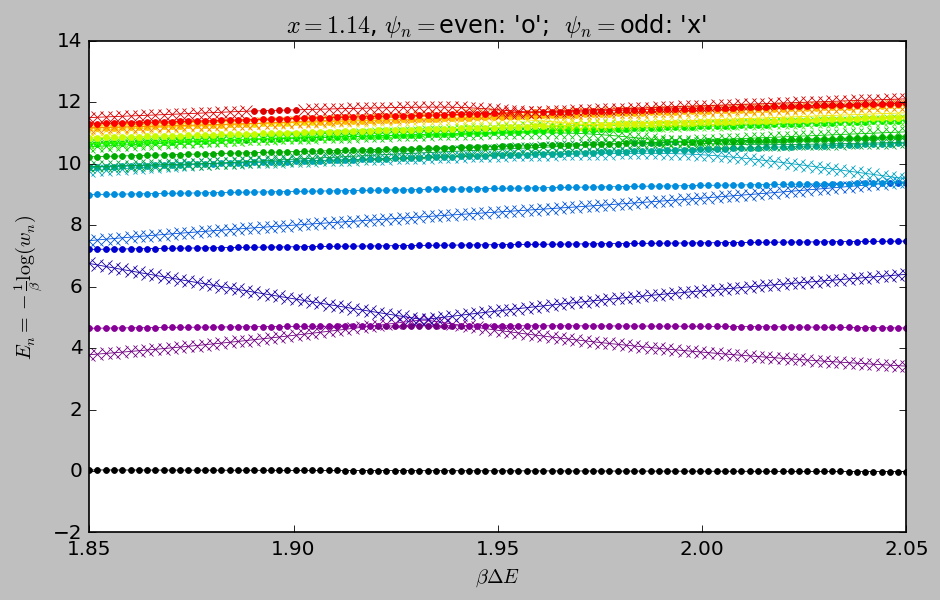

In [142]:
f, ax1 = plt.subplots(1, 1, figsize = (8,5), dpi=120, frameon=True)
for k in plotRange: 
    EigEnergies_pos = np.array([]); beta_pos = np.array([])
    EigEnergies_neg = np.array([]); beta_neg = np.array([])
    for j_i, j in enumerate(beta_list_fine): 
        if EigEnergies_record[j_i, k] >= 0: 
            EigEnergies_pos = np.append(EigEnergies_pos, -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i])
            beta_pos = np.append(beta_pos, beta_list_fine[j_i])
        else: 
            EigEnergies_neg = np.append(EigEnergies_neg, -np.log(np.abs(w_alph_list_fine[j_i][k]))/beta_list_fine[j_i])
            beta_neg = np.append(beta_neg, beta_list_fine[j_i])
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*EigEnergies[:,k], '-', linewidth=0.5, color=color_list[k])
    ax1.plot(beta_pos*levelSpace, beta_pos*EigEnergies_pos, color=color_list[k], linewidth=0, marker='.', markersize=7, label=str(k))
    ax1.plot(beta_neg*levelSpace, beta_neg*EigEnergies_neg, color=color_list[k], linewidth=0, marker='x', markersize=7)

ax1.set_ylabel(r"$E_n = -\frac{1}{\beta}\log(w_n)$")
ax1.set_xlabel(r"$\beta \Delta E$")
# ax1.legend(loc=3, fontsize=8)
# ax1.set_xlim(1, 5)
# ax1.set_ylim(0, 10)
f.tight_layout()
ax1.set_title(r"$x=1.14$, $\psi_n=$even: 'o';  $\psi_n=$odd: 'x' ")
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_energy_rescaled_wide_parityBoth.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


#### Plotting states

Plots_W/JJ_CM_eps0.5_wf_beta1.904545.png
Plots_W/JJ_CM_eps0.5_wf_beta1.924747.png
Plots_W/JJ_CM_eps0.5_wf_beta1.936869.png
Plots_W/JJ_CM_eps0.5_wf_beta2.05.png


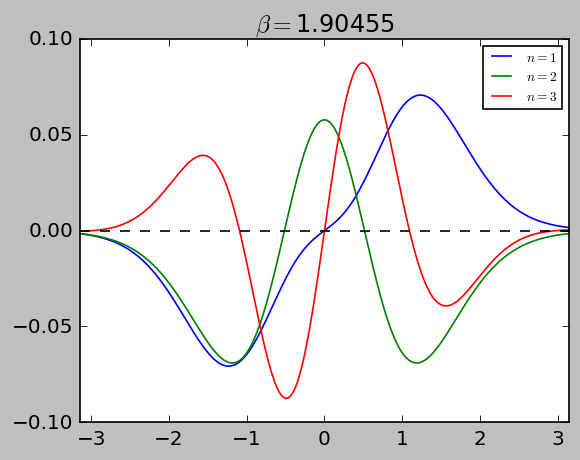

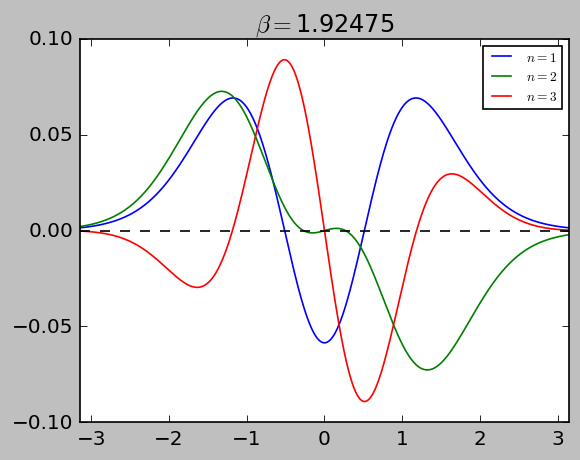

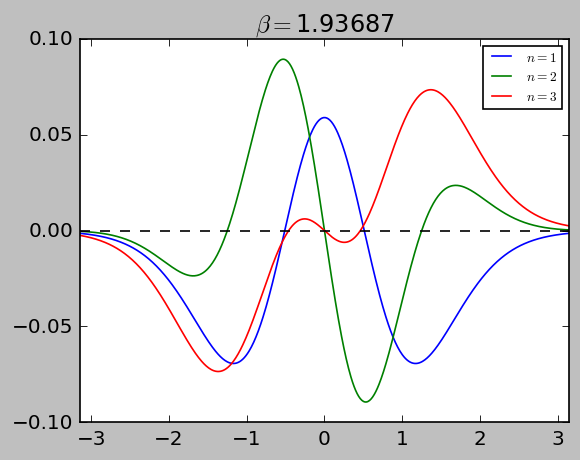

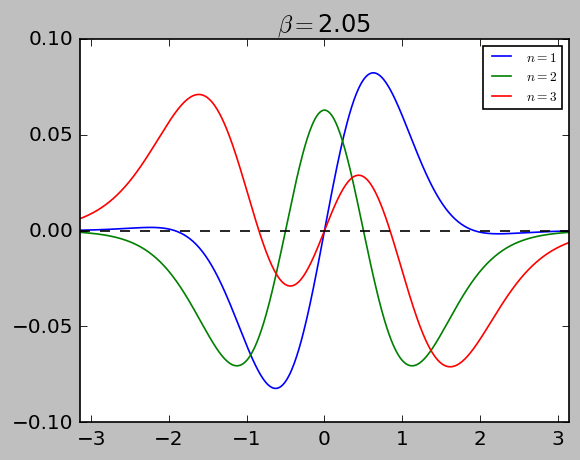

In [22]:
crossing_List = [34, 41, 45]
region_List = [27, 37, 43, -1]
for i in region_List:
    f, ax1 = plt.subplots(1, 1, figsize = (5,4), dpi=120, frameon=True)
    
    x1_range_q, psi_alph_betaj = readInWF_single("JJ_CM_states_nearMore", beta_list_fine[i])
    
    ax1.plot(x1_range_q, np.real(psi_alph_betaj[:,1]), '-', 
             label ="$n=1$")
    ax1.plot(x1_range_q, np.real(psi_alph_betaj[:,2]), '-', 
             label ="$n=2$")
    ax1.plot(x1_range_q, np.real(psi_alph_betaj[:,3]), '-', 
             label ="$n=3$")
    ax1.plot(x1_range_q, 0*np.real(psi_alph_betaj[:,3]), 'k--')
    
    ax1.legend(fontsize=8)
    ax1.set_xlim([-np.pi, np.pi])
    ax1.set_title(r"$\beta = $"+str(round(beta_list_fine[i]*levelSpace, 5)))
    f.tight_layout()

    beta = beta_list_fine[i]*levelSpace
    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_wf_beta"+ str(round(beta,6)) +".png"
    print(filename)
#     f.savefig(filename, dpi=200) 

#### Two-state reduction of W

In [4]:
def readInWF(filename_base, beta):     
    filename = filename_base + str(round(beta,6)) + ".txt"
    filename_weights = "JJ_CM_weights_nearMore" + str(round(beta,6)) + ".txt"
    ## Read the histogram array using Numpy commands. 
    w_alph = np.loadtxt("diagW/SingleT/"+filename_weights,dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/SingleT/"+filename,dtype = "complex", delimiter=',', comments='#')
    
    ## Sort based on energy values
    sorted_arg = np.argsort(-np.abs(w_alph))
    sorted_w_alph = np.zeros_like(w_alph)
    sorted_psi_alph = np.zeros_like(psi_alph)
    for n_j, n in enumerate(sorted_arg): 
        sorted_w_alph[n_j] = w_alph[n]
        sorted_psi_alph[:, n_j] = psi_alph[:, n]
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.append(np.flip(-1*np.arange(0,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx))
    # x1_range_q = np.arange(x1_min-5*sigma_x,x1_max+5*sigma_x+dx,dx)
    n_x1q = len(x1_range_q); 
    
    return x1_range_q, sorted_w_alph, sorted_psi_alph

def reconstruct_W(beta): 
    ## Read-in weights/states for given inverse-temperature
    x1_range_q, w_alph, psi_alph = readInWF("JJ_CM_states_nearMore", beta)

#     print(psi_alph.shape)
#     print("no. of weights=", len(w_alph))
#     print("inverse T=", beta_list_fine[j_i]*levelSpace, beta_list_fine[j_i])

    ## Construct the W-matrix from weights/states
    n_x1q = len(x1_range_q); 
    P = np.zeros((n_x1q,n_x1q))
    D = np.zeros((n_x1q,n_x1q))

    for i in range(n_x1q): 
        D[i,i] += np.real(w_alph[i])
        P[:,i] += np.real(psi_alph[:,i])

    W_mat_recon =  P@D@np.linalg.inv(P)
    return x1_range_q, w_alph, psi_alph, W_mat_recon


In [5]:
beta_list_fine = np.linspace(1.85, 2.05, 100) / levelSpace

##### Testing code

Plots_W_test/JJ_CM_eps0.5_W_dx0.01_recon.png


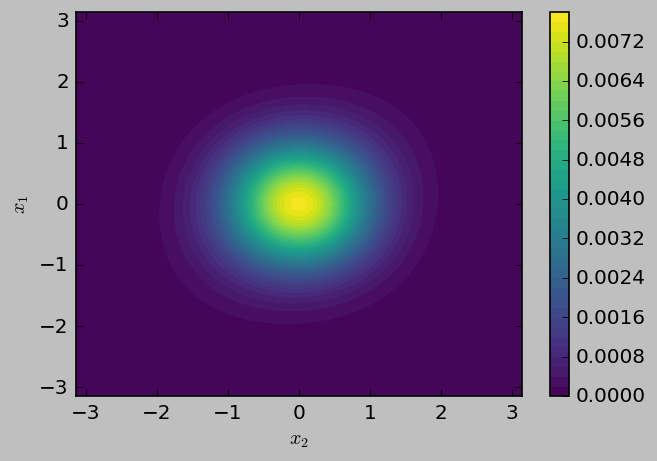

In [6]:
## Plot the resulting W-matrix
beta = beta_list_fine[20]
x1_range_q, w_alph, psi_alph, W_mat_recon = reconstruct_W(beta)

fig = plt.figure(figsize = (6,4), dpi=120)
ax = plt.axes()
heatmap = ax.contourf(x1_range_q, x1_range_q, W_mat_recon, 50, cmap='viridis')
ax.set_xlabel(r'$x_2$')
ax.set_ylabel(r'$x_1$')
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-np.pi, np.pi])
fig.colorbar(heatmap)
filename = "Plots_W_test/JJ_CM_eps"+str(eps)+"_W_dx"+str(dx)+"_recon.png"
print(filename)
# plt.savefig(filename, bbox_inches='tight', dpi=200) 

In [32]:
state_range = [1,3]

W_sub = np.zeros((len(state_range), len(state_range)))

for j_i, j in enumerate(state_range): 
    for k_i, k in enumerate(state_range): 
        W_sub[j_i, k_i] = psi_alph[:,k] @ W_mat_recon @ psi_alph[:,j]

print(W_sub)

[w_alph_sub, psi_alph_sub] = np.linalg.eigh(W_sub)

print("old weights:", [np.real(w_alph[1]), np.real(w_alph[3])])
print("new weights:", w_alph_sub)

print("subspace eigenstates:", psi_alph_sub)

[[-1.57922684e-02  1.33317471e-17]
 [-8.46769078e-18  3.74225157e-03]]
old weights: [-0.01579226841506515, 0.0037422515736266508]
new weights: [-0.01579227  0.00374225]
subspace eigenstates: [[-1.00000000e+00  4.33473194e-16]
 [-4.33473194e-16 -1.00000000e+00]]


/Library/Python/3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


##### Full Code

1.8904040404040408
Plots_W/JJ_CM_eps0.5_entropy_delta.png


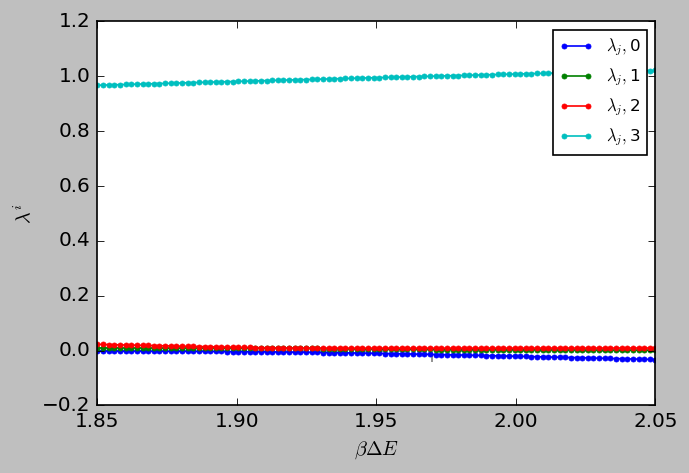

In [84]:
##Define the states for the subspace
chosen_state_j = 20; print(beta_list_fine[chosen_state_j]*levelSpace)
state_range = [0,1,2,3]
new_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
old_eig_list = np.zeros((len(state_range), len(beta_list_fine)))
new_psi_list = np.zeros((len(state_range), len(beta_list_fine), 4))

x_range_q, w_alph_j, psi_alph_j, W_mat_recon_j = reconstruct_W(beta_list_fine[chosen_state_j])
x_end_j = np.where(x_range_q == 3.14)[0][0]; x_beg_j = np.where(x_range_q == -3.14)[0][0]

##Compute the W sub-matrix 
for beta_i, beta in enumerate(beta_list_fine): 
    print(beta_i, "/",len(beta_list_fine), end='\r')
    x1_range_q, w_alph, psi_alph, W_mat_recon = reconstruct_W(beta)
    x_end = np.where(x1_range_q == 3.14)[0][0]; x_beg = np.where(x1_range_q == -3.14)[0][0]
    
    W_sub = np.zeros((len(state_range), len(state_range)))
    for j_i, j in enumerate(state_range): 
        for k_i, k in enumerate(state_range): 
            W_sub[j_i, k_i] = np.real(psi_alph_j[x_beg_j:x_end_j,k] @ W_mat_recon[x_beg:x_end, x_beg:x_end] @ psi_alph_j[x_beg_j:x_end_j,j])
    [w_alph_sub, psi_alph_sub] = np.linalg.eigh(W_sub)
    new_eig_list[:,beta_i] += w_alph_sub
    old_eig_list[:,beta_i] += np.real(w_alph[:4])
    new_psi_list[:,beta_i,:] += psi_alph_sub

## ==============================
##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (6,4), dpi=120, frameon=True)
ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
ax1.plot(beta_list_fine*0+1.97, np.linspace(-0.04,0.03,100), '--', color='grey')
for j in state_range: 
    ax1.plot(beta_list_fine*levelSpace, new_eig_list[j,:], '.-', label=r"$\lambda_j,$"+str(j))
ax1.legend(fontsize=10)
ax1.set_ylabel(r"$\lambda^i$")
ax1.set_xlabel(r"$\beta \Delta E$")

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_entropy_delta.png"
# f.savefig(filename, dpi=200) 
print(filename)

##### Plots of weights (pre- and post-diagonalization

Plots_W/JJ_CM_eps0.5_Wsub_weights.png


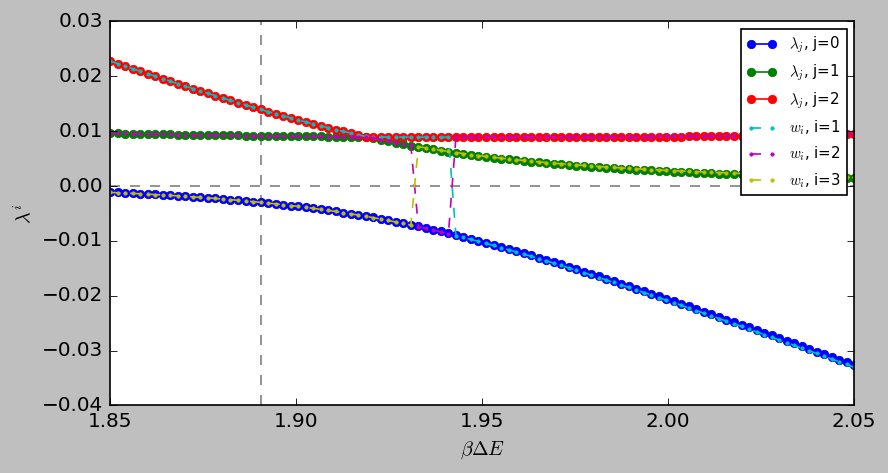

In [86]:
##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=120, frameon=True)
ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.04,0.03,100), '--', color='grey')

for j in state_range[:-1]: 
    ax1.plot(beta_list_fine*levelSpace, new_eig_list[j,:], '.-', markersize=10, label=r"$\lambda_j$, j="+str(j))
    
for j in state_range[1:]: 
    ax1.plot(beta_list_fine*levelSpace, old_eig_list[j,:], '.--', markersize=4, label=r"$w_i$, i="+str(j))
    
ax1.legend(fontsize=9)

ax1.set_ylabel(r"$\lambda^i$")
ax1.set_xlabel(r"$\beta \Delta E$")

filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_weights.png"
f.savefig(filename, dpi=200, bbox_inches='tight')
print(filename)

##### Plots of ovelraps between states

Plots_W/JJ_CM_eps0.5_Wsub_vector0.png
Plots_W/JJ_CM_eps0.5_Wsub_vector1.png
Plots_W/JJ_CM_eps0.5_Wsub_vector2.png
Plots_W/JJ_CM_eps0.5_Wsub_vector3.png


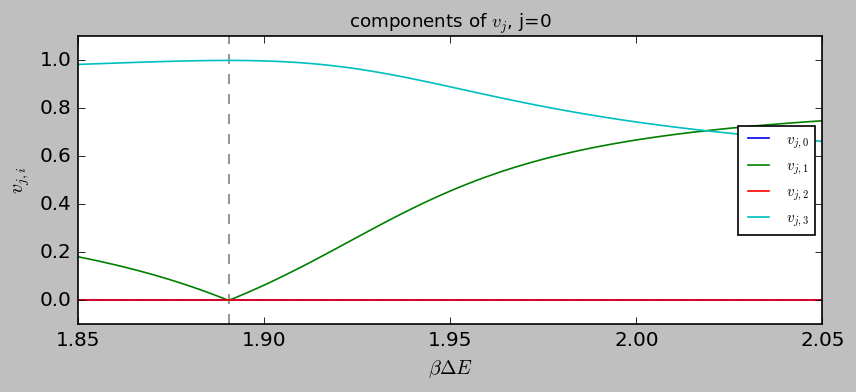

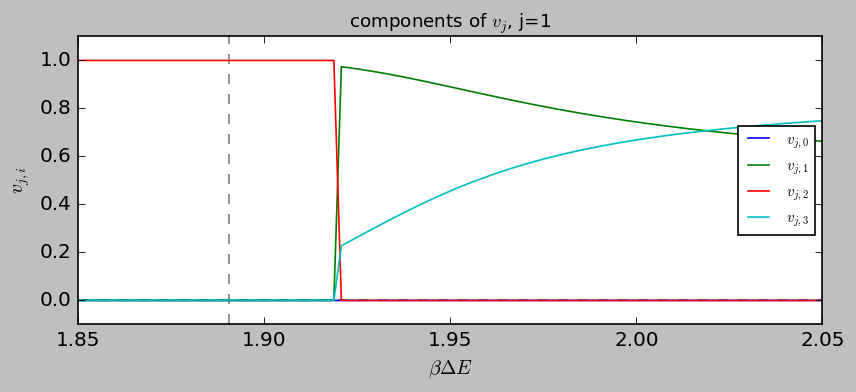

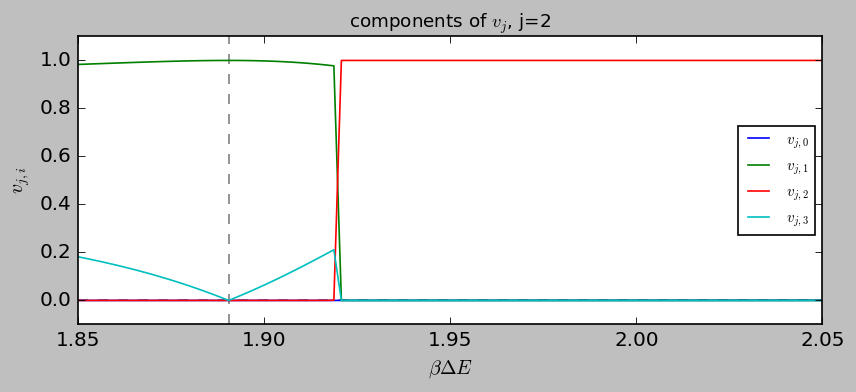

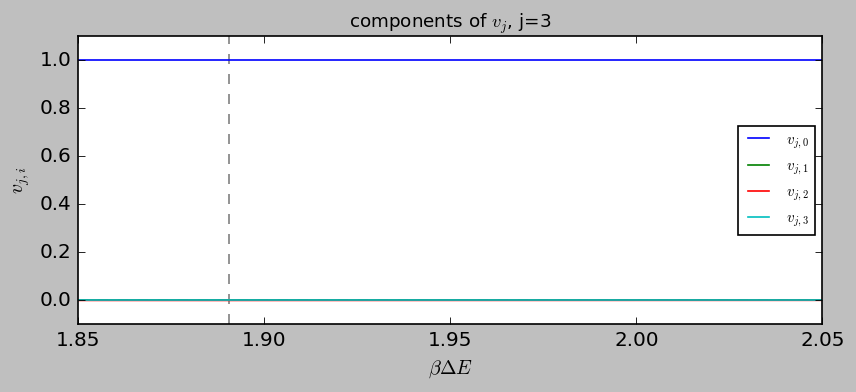

In [95]:
for j in state_range:
    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[0,:,j]), '-', label=r"$v_{j,0}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[1,:,j]), '-', label=r"$v_{j,1}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[2,:,j]), '-', label=r"$v_{j,2}$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_psi_list[3,:,j]), '-', label=r"$v_{j,3}$")
    # ax1.plot(beta_list_fine*levelSpace, new_eig_list[3,:], '.-', label=r"$\lambda_3$")
    ax1.legend(fontsize=9, loc=7)

    ax1.set_title("components of $v_j$, j="+str(j), fontsize=11)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_ylabel(r"$v_{j,i}$")
    ax1.set_xlabel(r"$\beta \Delta E$")
#     ax1.set_yscale('log')

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_vector"+str(j)+".png"
    f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

Plots_W/JJ_CM_eps0.5_Wsub_diff0.png
Plots_W/JJ_CM_eps0.5_Wsub_diff1.png
Plots_W/JJ_CM_eps0.5_Wsub_diff2.png
Plots_W/JJ_CM_eps0.5_Wsub_diff3.png


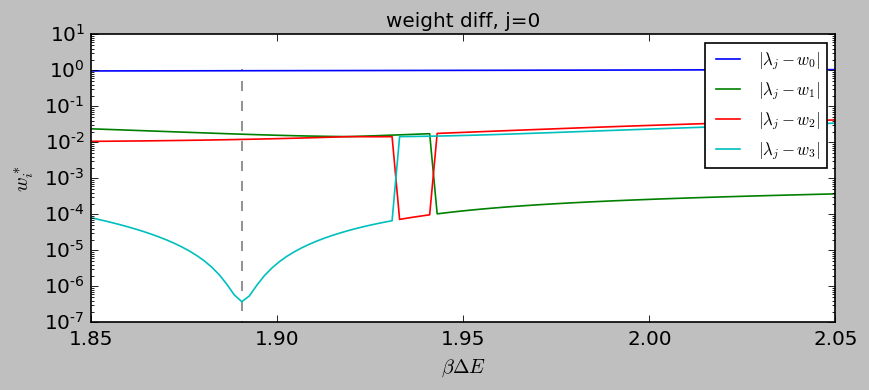

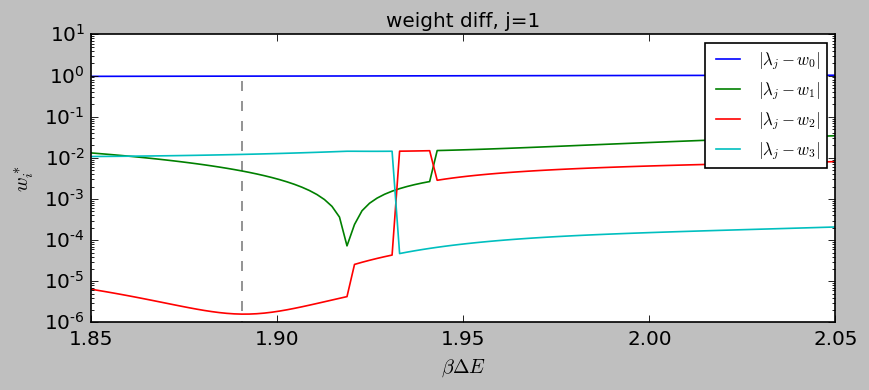

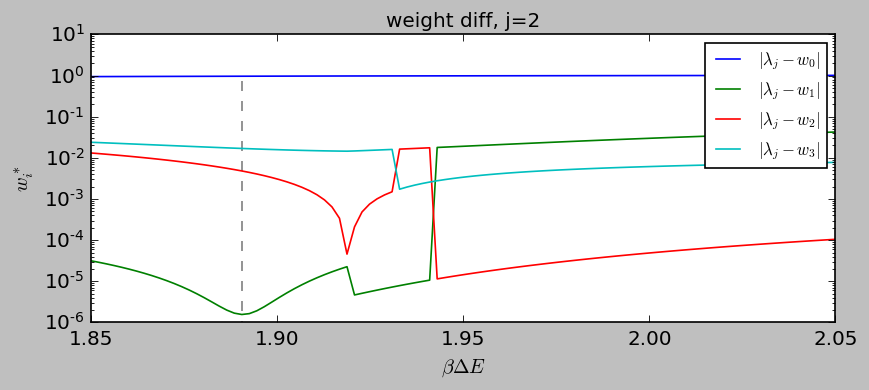

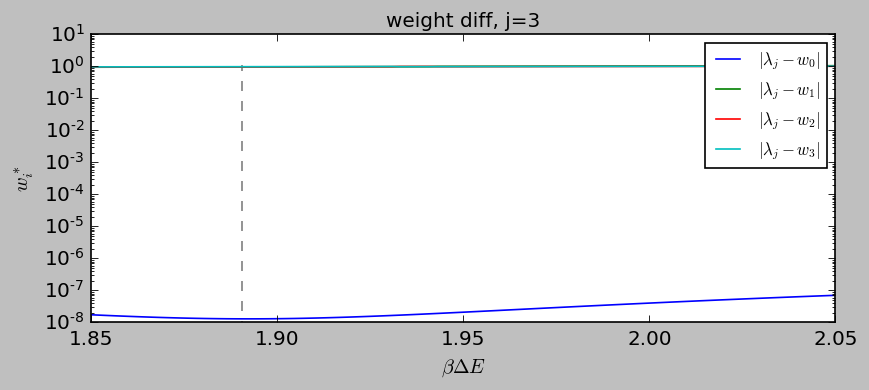

In [92]:
for j in range(0,4): 

    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=120, frameon=True)
    ax1.plot(beta_list_fine*levelSpace, beta_list_fine*0, '--', color='grey')
    ax1.plot(beta_list_fine*0+beta_list_fine[chosen_state_j]*levelSpace, np.linspace(-0.1,1.1,100), '--', color='grey')

    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[0,:]), '-', label=r"$|\lambda_j-w_0|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[1,:]), '-', label=r"$|\lambda_j-w_1|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[2,:]), '-', label=r"$|\lambda_j-w_2|$")
    ax1.plot(beta_list_fine*levelSpace, np.abs(new_eig_list[j,:]-old_eig_list[3,:]), '-', label=r"$|\lambda_j-w_3|$")

    ax1.legend(fontsize=10)
    ax1.set_ylabel(r"$w^*_i$")
    ax1.set_xlabel(r"$\beta \Delta E$")
    ax1.set_yscale("log")
    ax1.set_title("weight diff, j="+str(j), fontsize=12)

    filename = "Plots_W/JJ_CM_eps"+str(eps)+"_Wsub_diff"+str(j)+".png"
    f.savefig(filename, dpi=200, bbox_inches='tight')
    print(filename)
    
# print("n=0", np.abs(new_eig_list[3,:]-old_eig_list[0,:]))
# print("n=1", np.abs(new_eig_list[3,:]-old_eig_list[1,:]))
# print("n=2", np.abs(new_eig_list[3,:]-old_eig_list[2,:]))
# print("n=3", np.abs(new_eig_list[3,:]-old_eig_list[3,:]))

## Testing

In [ ]:
beta = beta_list_fine[-1]

sigma_x = beta*eps**2 / m
dx = 0.01
#Define extended range of x1
x1_max = np.pi
x1_min = -np.pi
x1_range_q = np.append(np.flip(-1*np.arange(0,x1_max+dx+sigma_x,dx)), np.arange(0,x1_max+dx+sigma_x,dx))
n_x1q = len(x1_range_q); 

print(sigma_x, beta, eps)
print(x1_range_q)

In [4]:
def createScript(jobName, filename, beta):
#     print("qsub" ,filename)
    file = open(filename,"w+")

    file.write("#!/bin/bash -l \n \n" )

    file.write("# Set SCC Project \n")
    file.write("#$ -P bunuc \n")

    file.write("# Specify hard time limit for the job. \n")
    file.write("#   The job will be aborted if it runs longer than this time. \n")
    file.write("#$ -l h_rt=12:00:00 \n \n")

    file.write("# Send an email when the job finishes or if it is aborted (by default no email is sent). \n")
    file.write("#$ -m a \n \n")

    file.write("# Reuest a node with at least 4 GB of memory per core \n")
    file.write("#$ -l mem_per_core=8G \n \n")

    file.write("# Request a paralell environemtn with _ cores \n")
    file.write("#$ -pe omp 1 \n \n")
    
    # ----- Assign Job Name -----
    file.write("# Give job a name \n")
    file.writelines(["#$ -N ", str(jobName), "\n \n"])

    file.write("# Combine output and error files into a single file \n")
    file.write("#$ -j y \n \n")

    file.write("# Specify the output file name \n")
    file.write("#$ -o cm_W_output.txt \n \n")

    file.write("# Keep track of information related to the current job \n \n")

    file.writelines(["module load python3", "\n \n"])
    file.writelines(["python3 CM_Solver_Wdiag_single.py ", str(beta), "\n \n"])

    file.close()

    
# beta_list_nearMore = np.linspace(0.01, 5.0, 50) / levelSpace
beta_list_nearMore = np.linspace(1.85, 2.05, 100) / levelSpace

for i in range(len(beta_list_nearMore)):
    jobname = 'cm_W' + str(beta_list_nearMore[i])
    filename = 'diagW/scripts_wide/cm_W_submit' + str(round(beta_list_nearMore[i], 6))+'.sh'
#     createScript(jobname, filename, beta_list_nearMore[i])
    
    print('qsub cm_W_submit' + str(round(beta_list_nearMore[i], 6))+'.sh')
    

qsub cm_W_submit3.966705.sh
qsub cm_W_submit3.971037.sh
qsub cm_W_submit3.975368.sh
qsub cm_W_submit3.9797.sh
qsub cm_W_submit3.984032.sh
qsub cm_W_submit3.988363.sh
qsub cm_W_submit3.992695.sh
qsub cm_W_submit3.997027.sh
qsub cm_W_submit4.001358.sh
qsub cm_W_submit4.00569.sh
qsub cm_W_submit4.010021.sh
qsub cm_W_submit4.014353.sh
qsub cm_W_submit4.018685.sh
qsub cm_W_submit4.023016.sh
qsub cm_W_submit4.027348.sh
qsub cm_W_submit4.03168.sh
qsub cm_W_submit4.036011.sh
qsub cm_W_submit4.040343.sh
qsub cm_W_submit4.044675.sh
qsub cm_W_submit4.049006.sh
qsub cm_W_submit4.053338.sh
qsub cm_W_submit4.05767.sh
qsub cm_W_submit4.062001.sh
qsub cm_W_submit4.066333.sh
qsub cm_W_submit4.070665.sh
qsub cm_W_submit4.074996.sh
qsub cm_W_submit4.079328.sh
qsub cm_W_submit4.083659.sh
qsub cm_W_submit4.087991.sh
qsub cm_W_submit4.092323.sh
qsub cm_W_submit4.096654.sh
qsub cm_W_submit4.100986.sh
qsub cm_W_submit4.105318.sh
qsub cm_W_submit4.109649.sh
qsub cm_W_submit4.113981.sh
qsub cm_W_submit4.118313.